# <center><font color='magenta'>**Assignment 2 for DA3**</font></center>
### <center>Central European University, 2024-2025</center>
### <left>Finding Fast Growing Firms</left>
### <left>2300715 - Saad Joiya</left>

# Import Libraries

In [5]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
warnings.filterwarnings("ignore")
import patsy
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [6]:
# Import the prewritten helper functions

color = ["blue","green", "red","orange"]  # Example colors, adjust as needed


def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.2, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.2, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.2, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.2, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.2, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

def create_calibration_plot(
    data: pd.DataFrame,
    file_name: str,
    prob_var: str,
    actual_var: str,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Function to create calibration curve.
    Returns calibration curve on a plot.

       Parameters
    ----------
    data : pd.DataFrame
        Your dataframe, containing the actual outcome and
        the predicted probabilities of that outcome
        by a model.
    file_name : str
        Filename to save. NOTE: this is note used for now.
    prob_var : str
        Name of the variable, containin predicted
        probabilities.
    actual_var : str
        Name of the actual outcome variable.
    y_lab: str
        Label on y axis of the plot.
    n_bins : int, default=10
        The number of bins, you would like to create.
        This is because with many values for the predicted probabilities,
        we may have few observations to look at for each value.
    breaks (optional): list or None
        You can speficy the breaks of the plot.
    """

    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    return (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(color=color[0], size=1, alpha=0.7, show_legend=False, na_rm=True)
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 1.2, 0.1))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 1.2, 0.1))
    )


# Import data

**Importing Dataset for Analysis**

In [9]:
data = pd.read_csv("https://osf.io/download/3qyut/")


In [10]:
pd.set_option('display.max_columns', None)
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,net_dom_sales,net_exp_sales,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,wages,D,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,NaN,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,NaN,NaN,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,NaN,NaN,0,364,0,2005,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,NaN,725.925903,996.296326,0.0,7225.925781,5896.296387,38140.742188,NaN,NaN,23844.445312,755.555542,64625.925781,1637.036987,1388.888916,725.925903,NaN,NaN,0,364,0,2006,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,NaN,1322.222168,570.370361,0.0,7951.852051,177.777771,40174.074219,NaN,NaN,22262.962891,0.000000,65100.000000,1633.333374,1388.888916,1322.222168,NaN,NaN,0,364,0,2007,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,NaN,1022.222229,714.814819,0.0,5233.333496,1392.592651,54274.074219,NaN,NaN,21107.408203,0.000000,78085.187500,1725.925903,1481.481445,1022.222229,NaN,NaN,0,365,0,2008,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,NaN,814.814819,-11044.444336,0.0,3259.259277,11.111111,41755.554688,NaN,NaN,13237.037109,-11074.074219,45388.890625,-9348.148438,1481.481445,814.814819,NaN,NaN,0,364,0,2009,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [64]:
data.isna().sum()

comp_id                      0
begin                        0
end                          0
COGS                    269572
amort                     8040
curr_assets                131
curr_liab                  131
extra_exp                18529
extra_inc                18529
extra_profit_loss        17203
finished_prod           270344
fixed_assets               131
inc_bef_tax               7437
intang_assets              140
inventories                131
liq_assets                 131
material_exp              8040
net_dom_sales           269572
net_exp_sales           269572
personnel_exp             8040
profit_loss_year          9884
sales                     7437
share_eq                   131
subscribed_cap             131
tang_assets               1470
wages                   269846
D                       287829
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             56457
exit_yea

**Dropping variables with many NAs**

In [66]:
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages", "begin","end","finished_prod","D"]
)
data = data.query("year !=2016")


In [67]:
data['year'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
      dtype=int64)


# Label engineering


**Temporarily filling NaN with a placeholder, it ensures that unstack() and stack() don’t drop missing data, preserving the original structure before reverting the placeholder back to NaN.**

In [70]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)


**The firm is aliveg, generate status_alive; if sales larger than zero and not-NA**

In [72]:
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

**Filtering Data for before 2014 as we analyze year 2012 and our fast growth feature would depend on 2013 and 2014 sales**

In [74]:
data = data.query("year <= 2014")


In [75]:
data["sales"].describe()

count    2.431690e+05
mean     4.860328e+05
std      3.869428e+06
min     -1.472559e+07
25%      4.940741e+03
50%      3.017778e+04
75%      1.091630e+05
max      1.110294e+08
Name: sales, dtype: float64

**No negative sales and creating taking log of sales**

In [77]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
) 
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [78]:
data.isna().sum()

year                         0
comp_id                      0
amort                   221485
curr_assets             213665
curr_liab               213665
extra_exp               222292
extra_inc               222292
extra_profit_loss       220962
fixed_assets            213665
inc_bef_tax             220951
intang_assets           213674
inventories             213665
liq_assets              213665
material_exp            221485
personnel_exp           221485
profit_loss_year        213665
sales                   220951
share_eq                213665
subscribed_cap          213665
tang_assets             215004
balsheet_flag           213540
balsheet_length         213540
balsheet_notfullyear    213540
founded_year            268057
exit_year               425723
ceo_count               268028
foreign                 268028
female                  268028
birth_year              319773
inoffice_days           268028
gender                  268028
origin                  268028
nace_mai

**Hybrid approach mixing 1 year and 2 year growth. This feature would be used to check fast growing companies on two years**

Approach: Two-Year Cumulative Growth (2014 vs. 2012)
The approach we use to measure growth is a hybrid one. First, we take difference in sales value over a longer horizon of 2 years (2014 and 2012). We take log sales (in millions) differences over two years. This method smooths out year-over-year volatility and focuses on sustained revenue expansion, which is often more meaningful in corporate finance. Many high-growth firms rely on strategic investments, R&D, and market expansion, which may take longer than a single year to reflect in revenues.

Secondly, we also check the log sales (in millions) differences over a shorter horizon of 1 year between 2013 and 2012. This would indicate which companies had explosive growth with in that year. 

A hybrid approach could involve defining fast growth as firms that are in the top 30% of future_d1_sales_mil_log and 40% of future_d2_sales_mil_log. This would ensure we capture both short-term explosive growth and sustained expansion over time, making the measure more robust. Additionally, we will control for industry differences by normalizing growth relative to industry medians (ind2) to ensure that firms are compared within their competitive environment.

This approach aligns with corporate valuation models, particularly in discounted cash flow (DCF) analysis, where long-term growth projections are more relevant than short-term spikes. However, a downside is that some early-stage high-growth firms may not appear in the fast-growth category if their biggest jump in sales happened within a single year rather than consistently over two years.



**grouping industries together so we can have ample data in each industry for comparing high growth companies** 

In [82]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [83]:
data["ind2_cat"].value_counts()

ind2_cat
99.0    214566
56.0    144502
55.0     29394
28.0     22587
33.0     18597
26.0     12989
27.0      7909
29.0      3766
60.0      3008
40.0      2415
30.0      2166
32.0      1633
20.0       584
35.0         4
Name: count, dtype: int64

**creating fast_growth feature**

In [85]:
# Sorting data on company and year before shifting
data = data.sort_values(by=["comp_id", "year"])

# Creating future sales growth variables for 1 and 2 years
data["future_d1_sales_mil_log"] = (
    data.groupby("comp_id")["sales_mil_log"].shift(-1) - data["sales_mil_log"]
)
data["future_d2_sales_mil_log"] = (
    data.groupby("comp_id")["sales_mil_log"].shift(-2) - data["sales_mil_log"]
)


# Compute industry-relative percentiles for 1-year and 2-year sales growth within each year
percentile_threshold_d1 = 70  # Top 30% within industry and 1 year
percentile_threshold_d2 = 60  # Top 40% within industry 2nd year

data["d1_growth_pctile"] = data.groupby(["ind2_cat", "year"])["future_d1_sales_mil_log"].transform(
    lambda x: x.rank(pct=True) * 100
)
data["d2_growth_pctile"] = data.groupby(["ind2_cat", "year"])["future_d2_sales_mil_log"].transform(
    lambda x: x.rank(pct=True) * 100
)

# Define fast-growing firms
data["fast_growth"] = (
   (data["d1_growth_pctile"] >= percentile_threshold_d1) &
    (data["d2_growth_pctile"] >= percentile_threshold_d2)
).astype(int)


# Check distribution over all years
data["fast_growth"].value_counts(normalize=True)

fast_growth
0    0.921176
1    0.078824
Name: proportion, dtype: float64

In [86]:
data.loc[data['year'] == 2012]["fast_growth"].value_counts(normalize=True)

fast_growth
0    0.878868
1    0.121132
Name: proportion, dtype: float64

In [87]:
data.loc[data['year'] == 2012].head(20)

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,status_alive,ln_sales,sales_mil,sales_mil_log,ind2_cat,future_d1_sales_mil_log,future_d2_sales_mil_log,d1_growth_pctile,d2_growth_pctile,fast_growth
324884,2012,1001034.0,140.740738,1.481481e+02,2.142963e+04,0.000000,0.000000,0.000000,3.407408e+02,-2474.073975,0.000000,0.000000e+00,25.925926,1.862963e+03,2.851852e+02,-2474.073975,0.000000e+00,-2.094074e+04,1481.481445,3.407408e+02,0.0,365.0,0.0,1990.0,NaN,2.0,0.0,0.5,1954.0,4895.5,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,0,0.000000,0.000000,0.000000,56.0,0.000000,0.000000,44.931314,38.742950,0
324885,2012,1001541.0,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,1.905667e+05,-7696.296387,0.000000,0.000000e+00,9048.148438,8.351852e+03,0.000000e+00,-7722.222168,1.203704e+03,1.912630e+05,200740.734375,1.905667e+05,0.0,365.0,0.0,2008.0,NaN,1.0,0.0,0.0,1974.0,3222.0,male,Domestic,5610.0,56.0,3.0,3.0,Central,2008-02-24,NaN,NaN,1,7.093159,0.001204,-6.722352,56.0,1.529395,1.401562,89.989433,83.713204,1
324886,2012,1002029.0,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,2.345926e+04,11818.518555,0.000000,6.777778e+02,15077.777344,9.842704e+05,4.103704e+04,9722.222656,1.136515e+06,9.314445e+04,11111.111328,2.345926e+04,0.0,365.0,0.0,2006.0,NaN,2.0,0.0,0.0,1975.0,3101.0,male,Domestic,2711.0,27.0,2.0,3.0,East,2006-07-03,NaN,0.458333,1,13.943477,1.136515,0.127966,27.0,-1.155013,-1.656969,7.022107,6.199461,0
324887,2012,1003200.0,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,0.000000e+00,-2337.037109,0.000000,0.000000e+00,22.222221,1.933333e+03,1.355556e+03,-2340.740723,2.785185e+03,-2.378519e+04,1851.851807,0.000000e+00,0.0,365.0,0.0,2003.0,2014.0,2.0,0.0,1.0,NaN,1754.0,female,Domestic,5630.0,56.0,3.0,1.0,Central,2003-10-21,2014-08-09,NaN,1,7.932070,0.002785,-5.883441,56.0,NaN,NaN,NaN,NaN,0
324888,2012,1004012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,0
324889,2012,1004898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,0
324890,2012,1007261.0,0.000000,2.555556e+02,9.207407e+03,0.000000,0.000000,0.000000,0.000000e+00,-4670.370605,0.000000,0.000000e+00,255.555557,0.000000e+00,4.670371e+03,-4670.370605,0.000000e+00,-8.951852e+03,1851.851807,0.000000e+00,0.0,365.0,0.0,2010.0,2015.0,1.0,0.0,0.0,1962.0,1539.0,male,Domestic,5610.0,56.0,3.0,1.0,Central,2010-08-26,2015-11-19,0.083333,0,0.000000,0.000000,0.000000,56.0,NaN,NaN,NaN,NaN,0
324891,2012,1011889.0,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,9.335741e+05,96751.851562,1537.036987,1.186667e+04,131766.671875,2.046593e+05,9.261481e+04,96751.851562,4.336667e+05,1.071011e+06,17481.482422,9.320371e+05,0.0,365.0,0.0,1992.0,NaN,1.0,0.0,0.0,1946.0,6198.0,male,Domestic,5510.0,55.0,3.0,2.0,West,1992-11-09,NaN,1.621212,1,12.980031,0.433667,-0.835479,55.0,0.019109,0.086522,55.037742,54.680484,0
324892,2012,1014183.0,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,1.182296e+05,-1429.629639,0.000000,0.000000e+00,18585.185547,6.674445e+04,5.571111e+04,-2351.851807,1.297296e+05,3.098852e+05,11111.111328,1.182296e+05,0.0,365.0,0.0,2001.0,NaN,1.0,0.0,0.0,1946.0,3594.0,male,Domestic,5510.0,55.0,3.0,2.0,Central,2001-12-21,NaN,0.715278,1,11.773208,0.129730,-2.042303,55.0,-0.110044,-0.249819,25.139481,20.034542,0
324893,2012,1018301.0,0.00

In [88]:
data["past_d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [89]:
data.columns

Index(['year', 'comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'founded_year', 'exit_year', 'ceo_count',
       'foreign', 'female', 'birth_year', 'inoffice_days', 'gender', 'origin',
       'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date',
       'exit_date', 'labor_avg', 'status_alive', 'ln_sales', 'sales_mil',
       'sales_mil_log', 'ind2_cat', 'future_d1_sales_mil_log',
       'future_d2_sales_mil_log', 'd1_growth_pctile', 'd2_growth_pctile',
       'fast_growth', 'past_d1_sales_mil_log'],
      dtype='object')

# Sample design

In [91]:
data = data.query("year==2012 & status_alive == 1")
# looking at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")


In [92]:
data["fast_growth"].value_counts()


fast_growth
0    16641
1     5082
Name: count, dtype: int64

# Feature engineering

**Calculating age of firms and classifying them as new if their age is less than 1**


In [95]:
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["past_d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["past_d1_sales_mil_log"])
)
data["new"] = np.where(data["past_d1_sales_mil_log"].isna(), 1, data["new"])
data["past_d1_sales_mil_log"] = np.where(
    data["past_d1_sales_mil_log"].isna(), 0, data["past_d1_sales_mil_log"]
)

In [96]:
data["new"].describe()


count    21723.000000
mean         0.259264
std          0.438241
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: new, dtype: float64

**Creating firm characteristics**

In [98]:
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


**Assets can't be negative. Change them to 0 and add a flag.**

In [100]:

data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [101]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [102]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

**pl variables would be normalized using sales and bs variables with total assets**

In [104]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [105]:
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [106]:
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [107]:
data.columns

Index(['year', 'comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'founded_year', 'exit_year', 'ceo_count',
       'foreign', 'female', 'birth_year', 'inoffice_days', 'gender', 'origin',
       'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date',
       'exit_date', 'labor_avg', 'status_alive', 'ln_sales', 'sales_mil',
       'sales_mil_log', 'ind2_cat', 'future_d1_sales_mil_log',
       'future_d2_sales_mil_log', 'd1_growth_pctile', 'd2_growth_pctile',
       'fast_growth', 'past_d1_sales_mil_log', 'age', 'new',
       'foreign_management', 'gender_m', 'm_region_loc', 'flag_asset_problem',
       'total_assets_bs', 'extra_exp_pl', 'extra_inc_pl',
       

**Creating flags, and winsorizing tails**

In [109]:
# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

#Creating flag if value > 1 for model to take this information into consideration
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)

#Trimming the value of the variable at 1
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)

#Creating flag error if value < 0 for model to take this information into consideration as value cannot be < 0
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)

#Trimming the value of the variable at 0
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [110]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]


#These can have any value so trimming at -1 and 1 and for value = 0, creating a flag

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [111]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


**Calculating CEO age and creating flag variables for it**

In [113]:
# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)



In [114]:
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [115]:
for col in ['sales_mil_log', 'age', 'labor_avg_mod']:
    data[col] = winsorize(data[col], limits=[0.01, 0.01])  # 1% Winsorization

In [116]:
for col in ['amort', 'ceo_count', 'inoffice_days']:
    data[col] = winsorize(data[col], limits=[0.01, 0.01])  # 1% Winsorization

**Checking distribution of some numeric variables to check candidates for log-transformation**

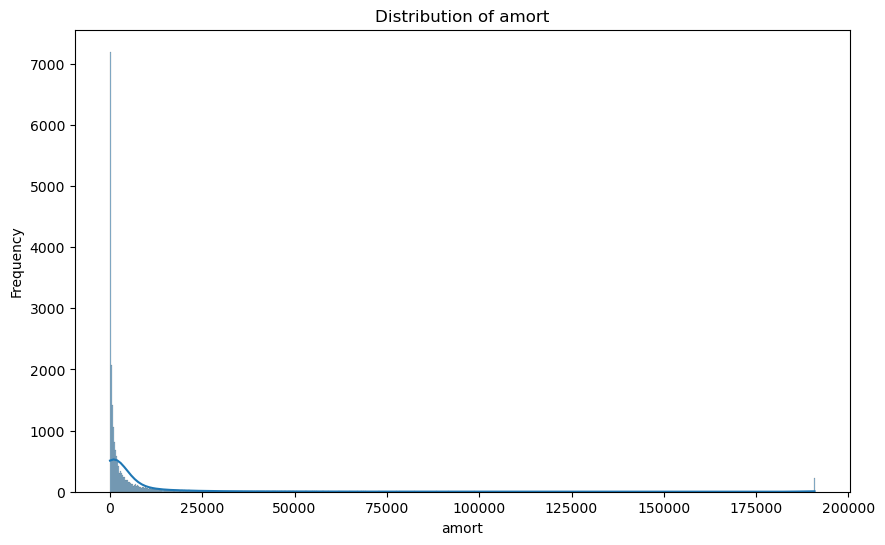

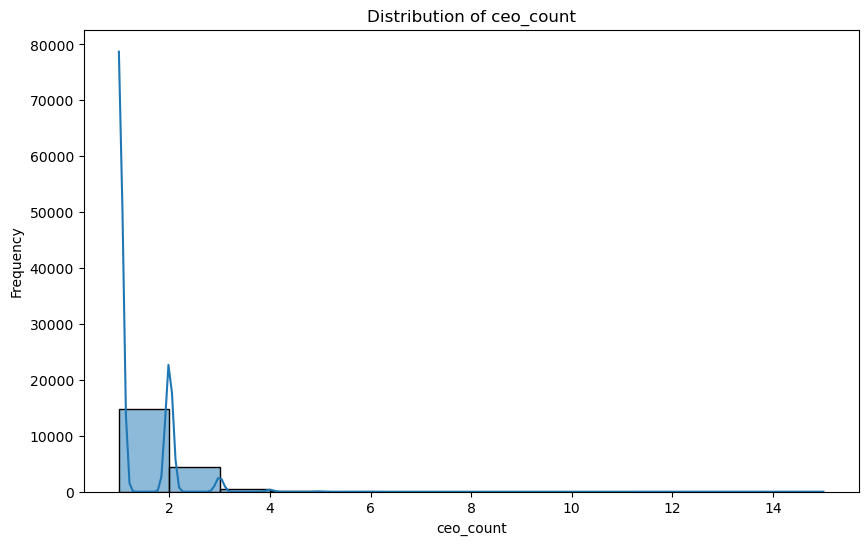

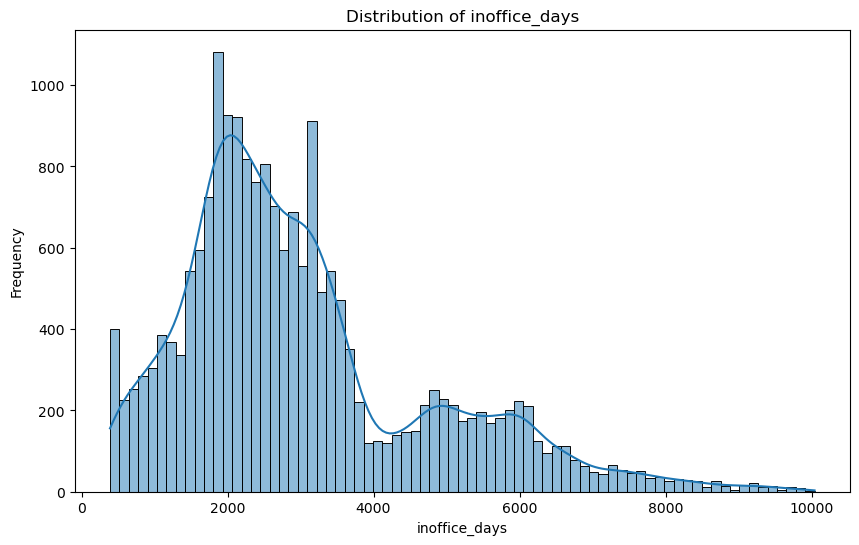

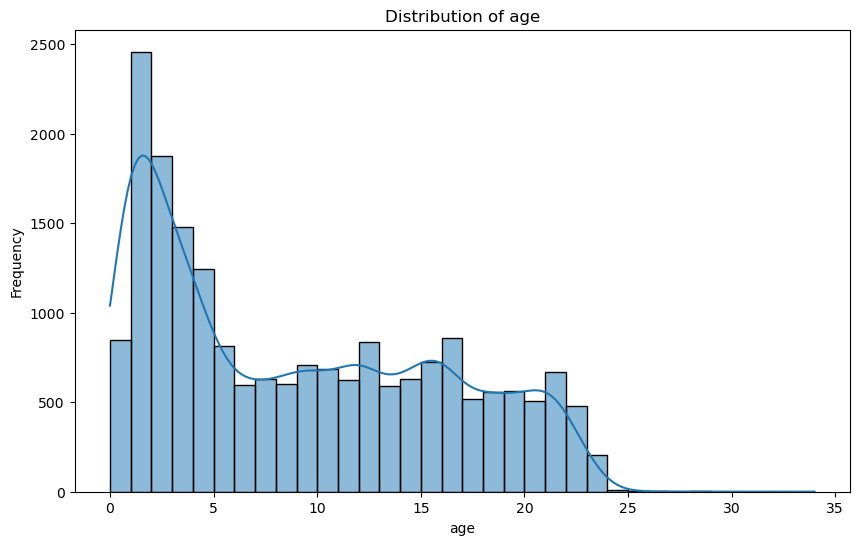

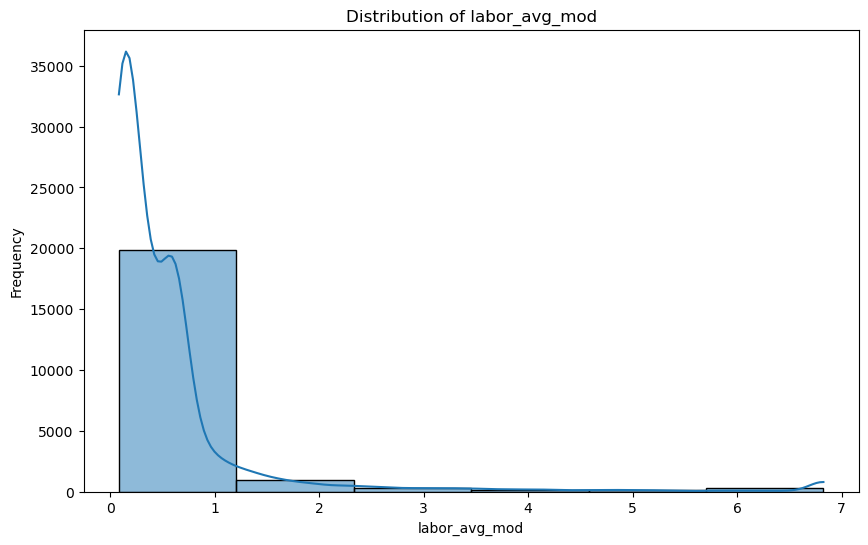

In [118]:
numeric_cols = ['amort','ceo_count','inoffice_days','age','labor_avg_mod']

# Creating histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    # Automatically determine bin width based on IQR (Interquartile Range)
    q25, q75 = np.percentile(data[col].dropna(), [25, 75])
    bin_width = 2 * (q75 - q25) * len(data[col]) ** (-1/3)  # Freedman-Diaconis rule
    bin_width = max(bin_width, 1)  # Ensure bin width is reasonable
    
    sns.histplot(data[col], bins=int((data[col].max() - data[col].min()) / bin_width), kde=True)
    
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()


In [119]:
data['ln_amort'] = np.log(data["amort"])
data['ln_ceo_count'] = np.log(data["ceo_count"])
data['ln_inoffice_days'] = np.log(data["inoffice_days"])
data['ln_age'] = np.log(data["age"]+0.1)
data['ln_labor_avg_mod'] = np.log(data["labor_avg_mod"])

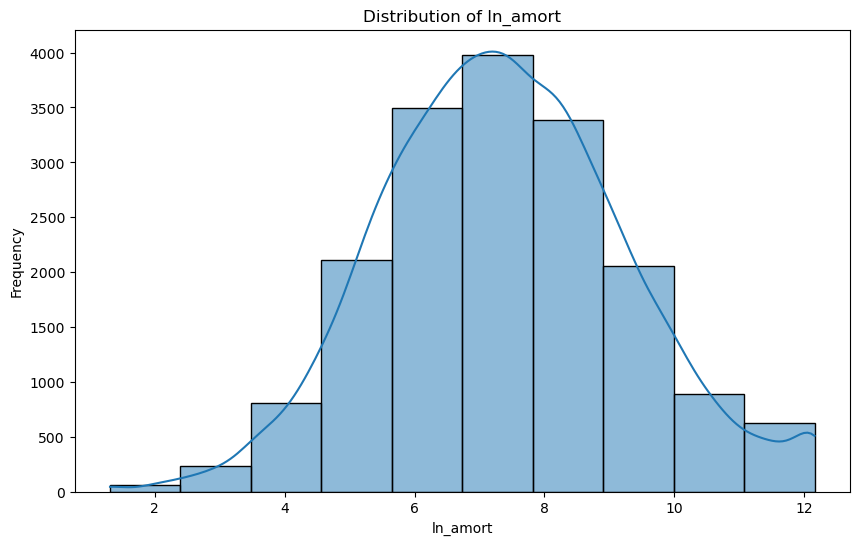

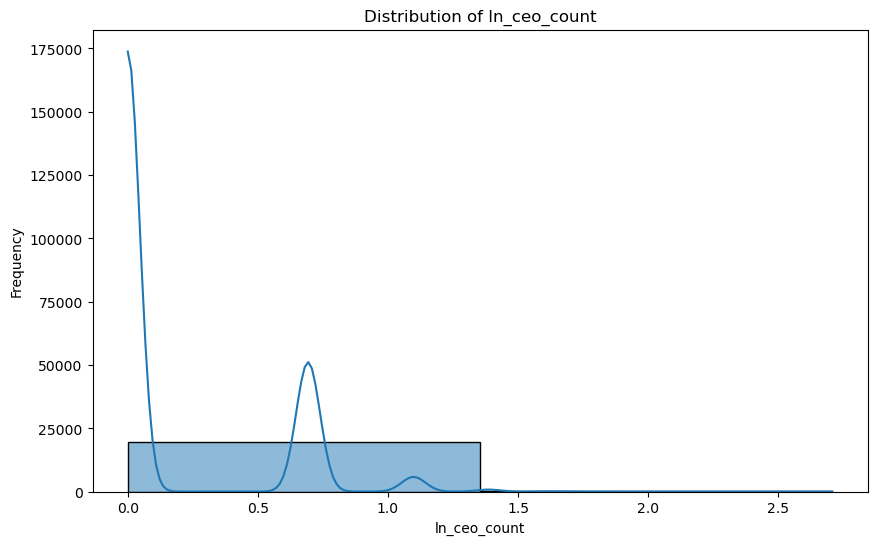

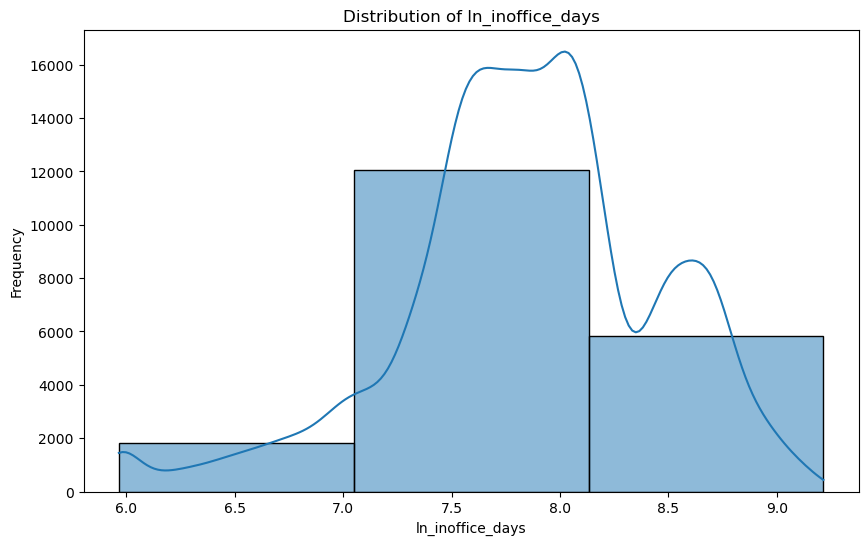

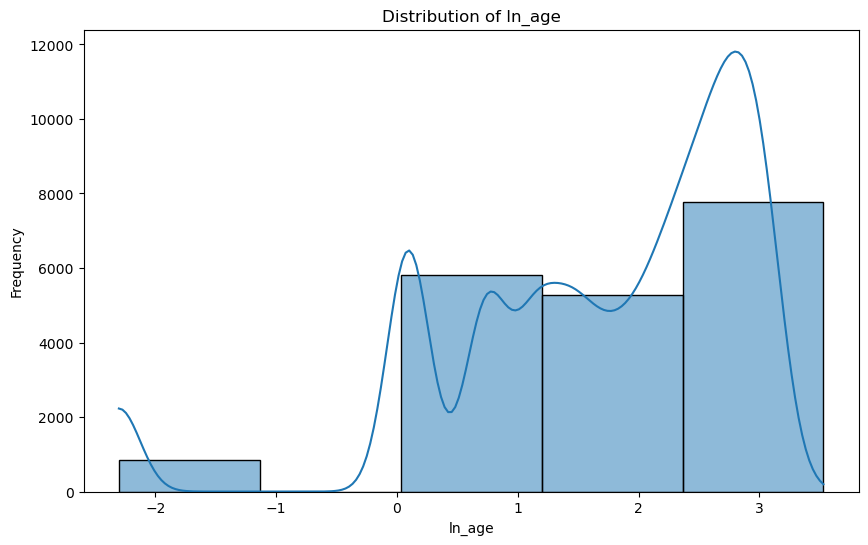

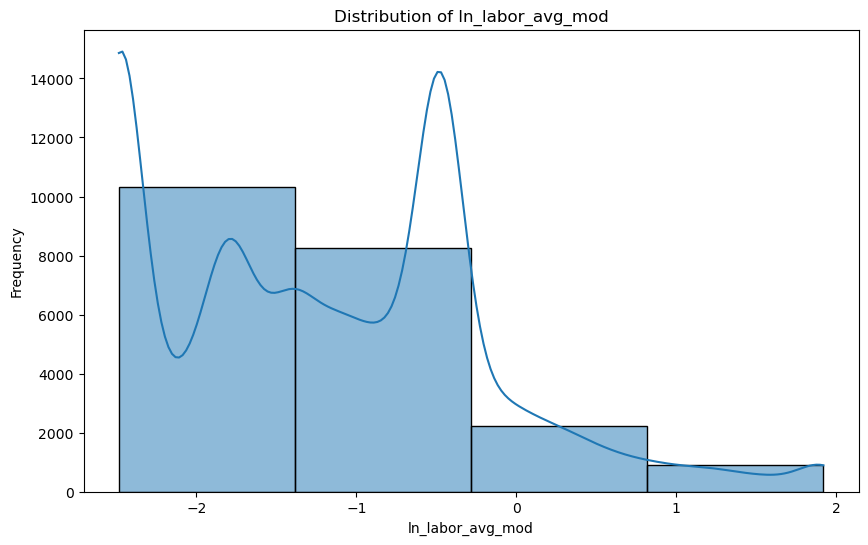

In [120]:
# Selecting only numeric columns
numeric_cols = ['ln_amort','ln_ceo_count','ln_inoffice_days','ln_age','ln_labor_avg_mod']

# Creating histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    # Automatically determine bin width based on IQR (Interquartile Range)
    q25, q75 = np.percentile(data[col].dropna(), [25, 75])
    bin_width = 2 * (q75 - q25) * len(data[col]) ** (-1/3)  # Freedman-Diaconis rule
    bin_width = max(bin_width, 1)  # Ensure bin width is reasonable
    
    sns.histplot(data[col], bins=int((data[col].max() - data[col].min()) / bin_width), kde=True)
    
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()


**Creating category type variables**

In [122]:
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")



**Creating polynomial variable for log sales in millions**

In [124]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

**Create a graph for fast growth against log sales in millions**

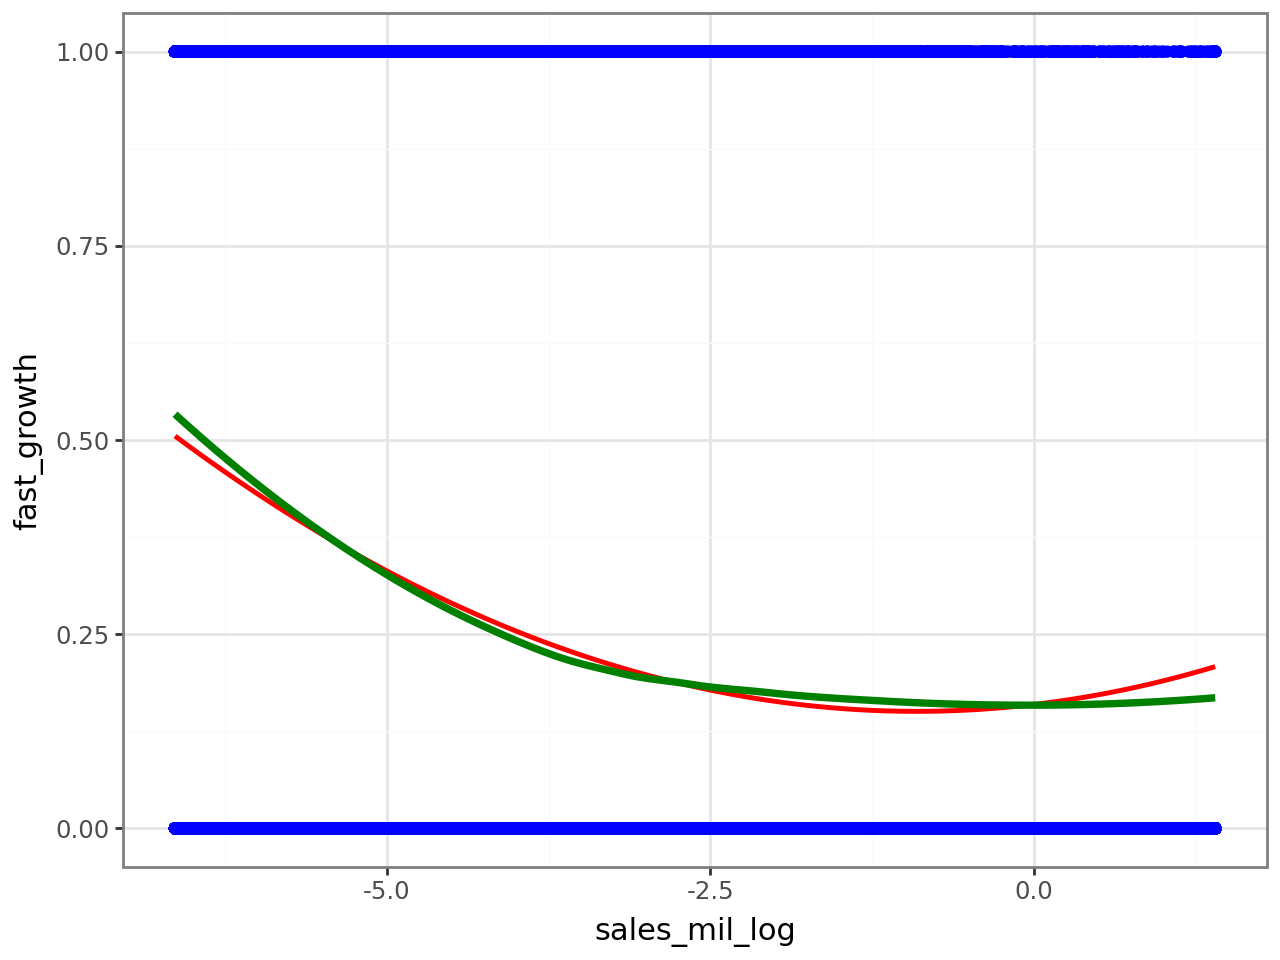

In [126]:
(
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color="blue")
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color="red", se=False)
    + geom_smooth(method="loess", color="green", se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="fast_growth")
    + theme_bw()
)


In [127]:
# Linear regressions
ols_s = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     442.1
Date:                Fri, 28 Feb 2025   Prob (F-statistic):          6.16e-189
Time:                        17:28:54   Log-Likelihood:                -11717.
No. Observations:               21723   AIC:                         2.344e+04
Df Residuals:                   21720   BIC:                         2.346e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1595      0.007  

**Generating flag variables for sales**

In [129]:
data["flag_low_d1_sales_mil_log"] = np.where(data["past_d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["past_d1_sales_mil_log"] > 1.5, 1, 0)
data["past_d1_sales_mil_log_mod"] = np.where(
    data["past_d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["past_d1_sales_mil_log"] > 1.5, 1.5, data["past_d1_sales_mil_log"]),
)
data["past_d1_sales_mil_log_mod_sq"] = data["past_d1_sales_mil_log_mod"] ** 2


In [130]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [131]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [132]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


**Graph of past year sales vs fast growth in 2012**

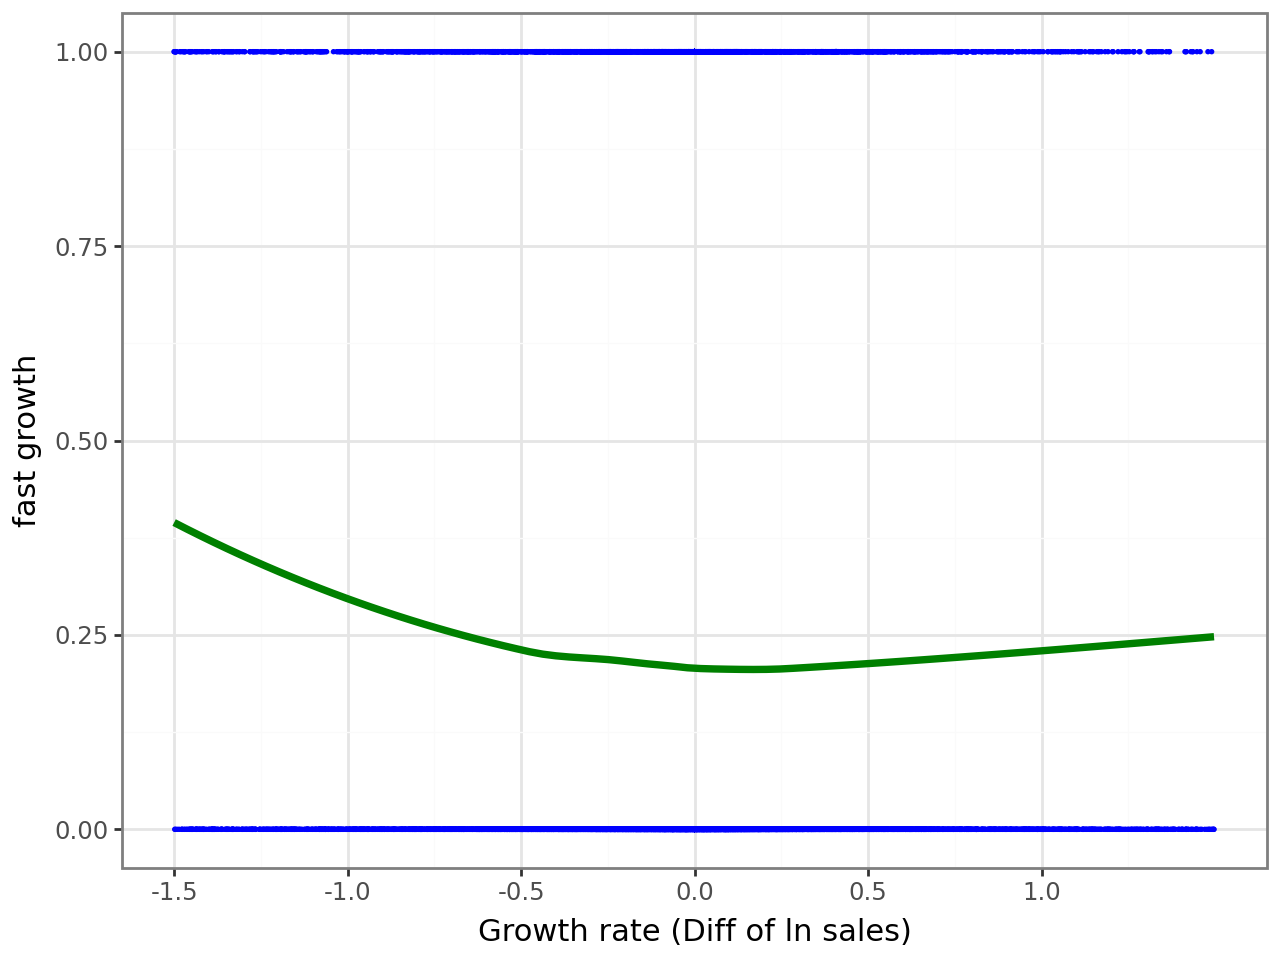

In [134]:
(
    ggplot(data, aes(x="past_d1_sales_mil_log", y="fast_growth"))
    + geom_point(size=0.1, color = "blue")
    + geom_smooth(method="loess", color="green", se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast growth")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=np.arange(-1.5, 1.5, 0.5))
    + theme_bw()
)


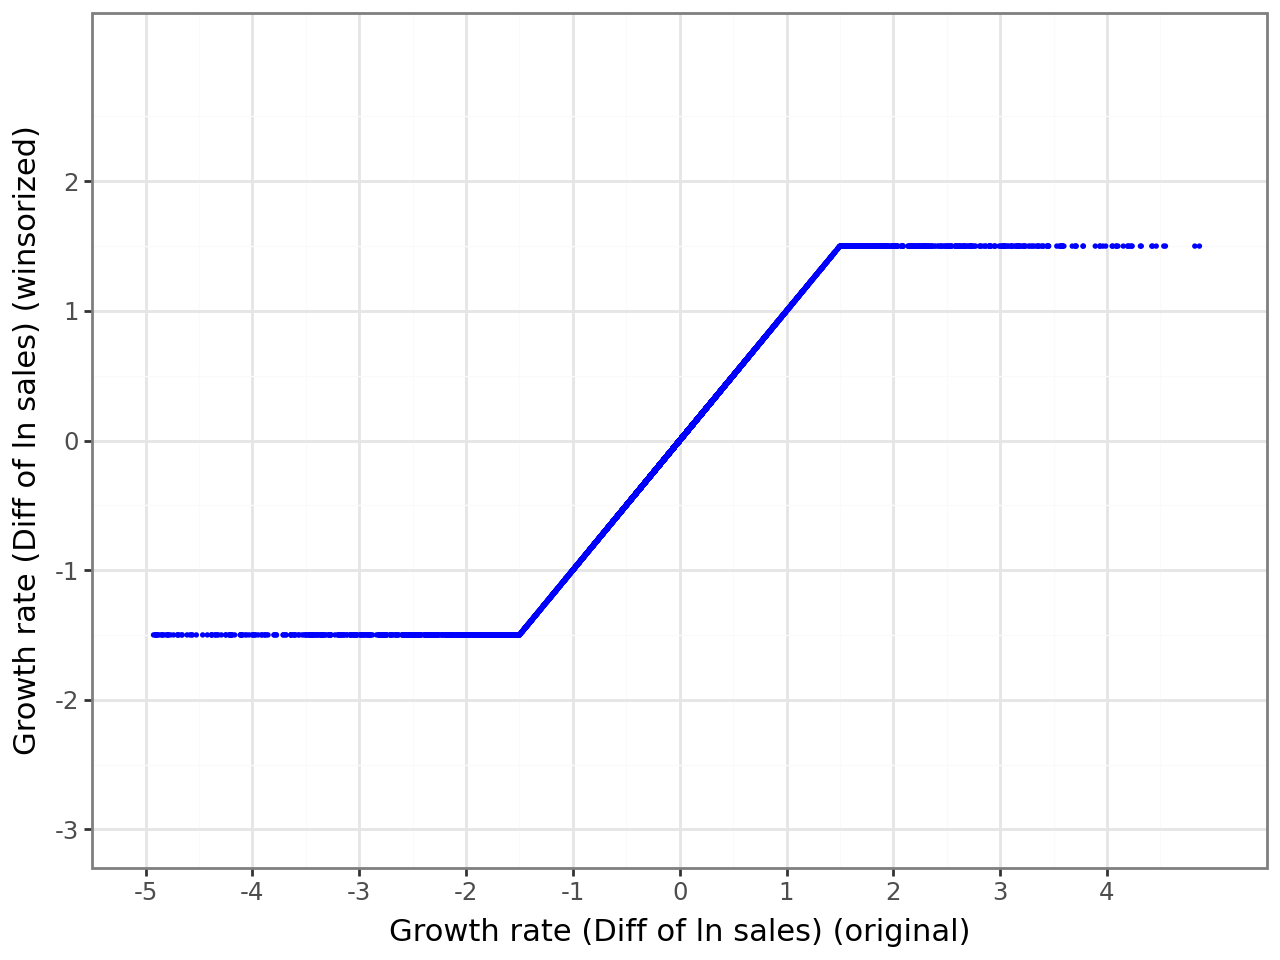

In [135]:
(
    ggplot(data, aes(x="past_d1_sales_mil_log", y="past_d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color = "blue")
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=np.arange(-5, 5, 1))
    + scale_y_continuous(limits=(-3, 3), breaks=np.arange(-3, 3, 1))
    + theme_bw()
)


In [136]:
for col in ['total_assets_bs']:
    data[col] = winsorize(data[col], limits=[0.01, 0.01])  # 1% Winsorization

In [137]:
data['ln_total_assets_bs'] = np.log(data["total_assets_bs"])

**Distribution of log of total assests**

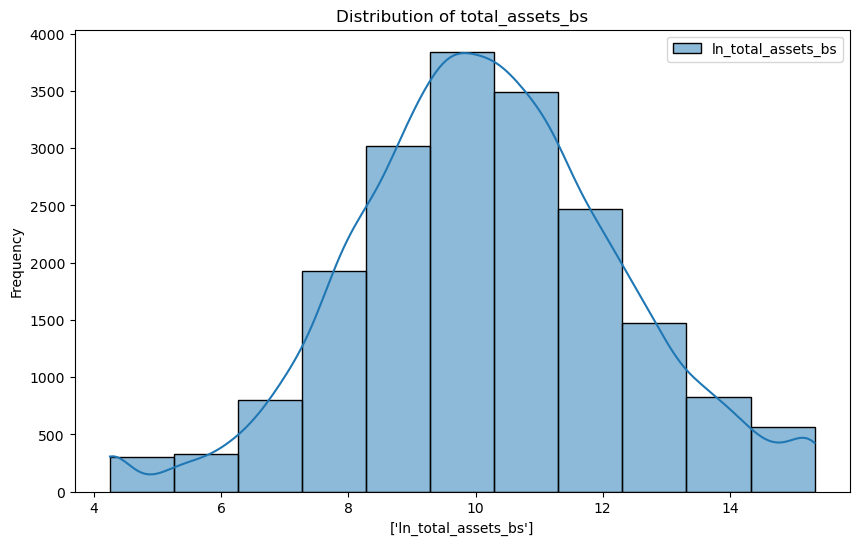

In [139]:
numeric_cols = ['ln_total_assets_bs']

plt.figure(figsize=(10, 6))
    
# Automatically determine bin width based on IQR (Interquartile Range)
q25, q75 = np.percentile(data[numeric_cols].dropna(), [25, 75])
bin_width = 2 * (q75 - q25) * len(data[numeric_cols]) ** (-1/3)  # Freedman-Diaconis rule
bin_width = max(bin_width, 1)  # Ensure bin width is reasonable
    
sns.histplot(data[numeric_cols], bins=int((data[numeric_cols].max() - data[numeric_cols].min()) / bin_width), kde=True)
#plt.xlim(0,2000000)
plt.xlabel(numeric_cols)
plt.ylabel("Frequency")
plt.title(f"Distribution of {col}")
plt.show()


In [140]:
data.head()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,status_alive,ln_sales,sales_mil,sales_mil_log,ind2_cat,future_d1_sales_mil_log,future_d2_sales_mil_log,d1_growth_pctile,d2_growth_pctile,fast_growth,past_d1_sales_mil_log,age,new,foreign_management,gender_m,m_region_loc,flag_asset_problem,total_assets_bs,extra_exp_pl,extra_inc_pl,extra_profit_loss_pl,inc_bef_tax_pl,inventories_pl,material_exp_pl,profit_loss_year_pl,personnel_exp_pl,intang_assets_bs,curr_liab_bs,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,extra_exp_pl_flag_high,extra_inc_pl_flag_high,inventories_pl_flag_high,material_exp_pl_flag_high,personnel_exp_pl_flag_high,curr_liab_bs_flag_high,liq_assets_bs_flag_high,subscribed_cap_bs_flag_high,extra_exp_pl_flag_error,extra_inc_pl_flag_error,inventories_pl_flag_error,material_exp_pl_flag_error,personnel_exp_pl_flag_error,curr_liab_bs_flag_error,liq_assets_bs_flag_error,subscribed_cap_bs_flag_error,extra_profit_loss_pl_flag_low,inc_bef_tax_pl_flag_low,profit_loss_year_pl_flag_low,share_eq_bs_flag_low,extra_profit_loss_pl_flag_high,inc_bef_tax_pl_flag_high,profit_loss_year_pl_flag_high,share_eq_bs_flag_high,extra_profit_loss_pl_flag_zero,inc_bef_tax_pl_flag_zero,profit_loss_year_pl_flag_zero,share_eq_bs_flag_zero,extra_profit_loss_pl_quad,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,labor_avg_mod,flag_miss_labor_avg,ln_amort,ln_ceo_count,ln_inoffice_days,ln_age,ln_labor_avg_mod,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,past_d1_sales_mil_log_mod,past_d1_sales_mil_log_mod_sq,ln_total_assets_bs
324885,2012,1001541.0,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,190566.671875,-7696.296387,0.000000,0.000000,9048.148438,8351.851562,0.000000,-7722.222168,1.203704e+03,1.912630e+05,200740.734375,190566.671875,0.0,365.0,0.0,2008.0,NaN,1.0,0.0,0.0,1974.0,3222.0,male,Domestic,5610.0,56.0,3.0,3.0,Central,2008-02-24,NaN,NaN,1,7.093159,0.001204,-6.636880,56.0,1.529395,1.401562,89.989433,83.713204,1,-6.722352,4.0,0.0,0.0,male,Central,0.0,2.001963e+05,0.0,0.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.006512,0.951899,0.045196,0.048101,0.955377,1.000000,0.951899,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.000000,1.000000,0.912745,38.000000,0,0,0,0.621691,1,6.176868,0.000000,8.077758,1.410987,-0.475312,44.048181,1,0,-1.500000,2.250000,12.207054
324886,2012,1002029.0,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,23459.259766,11818.518555,0.000000,677.777771,15077.777344,984270.375000,41037.035156,9722.222656,1.136515e+06,9.314445e+04,11111.111328,23459.259766,0.0,365.0,0.0,2006.0,NaN,2.0,0.0,0.0,1975.0,3101.0,male,Domestic,2711.0,27.0,2.0,3.0,East,2006-07-03,NaN,0.458333,1,13.943477,1.136515,0.127966,27.0,-1.155013,-1.656969,7.022107,6.199461,0,0.684448,6.0,0.0,0.0,male,East,0.0,2.273444e+05,0.0,0.000000,0.000000,0.010399,0.000596,0.866043,0.008554,0.036108,0.000000,0.529788,0.103188,0.066321,0.896812,0.409706,0.048873,0.103188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.000108,0.000073,0.167859,37.000000,0,0,0,0.458333,0,9.611103,0.693147,8.039480,1.808289,-0.780159,0.016375,0,0,0.684448,0.468469,12.334222
324887,2012,1003200.0,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,0.000000,-2337.037109,0.000000,0.000000,22.222221,1933.333374,1355.555542,-2340.740723,2.785185e+03,-2.378519e+04,1851

**Dropping redundant or helper variables**

In [142]:
data.drop(['gender','nace_main','founded_date','exit_date','ind','ind2','future_d1_sales_mil_log','future_d2_sales_mil_log','d1_growth_pctile','d2_growth_pctile','region_m'], axis = 1, inplace = True)

In [143]:
for col in data.columns:
    print(col)

year
comp_id
amort
curr_assets
curr_liab
extra_exp
extra_inc
extra_profit_loss
fixed_assets
inc_bef_tax
intang_assets
inventories
liq_assets
material_exp
personnel_exp
profit_loss_year
sales
share_eq
subscribed_cap
tang_assets
balsheet_flag
balsheet_length
balsheet_notfullyear
founded_year
exit_year
ceo_count
foreign
female
birth_year
inoffice_days
origin
urban_m
labor_avg
status_alive
ln_sales
sales_mil
sales_mil_log
ind2_cat
fast_growth
past_d1_sales_mil_log
age
new
foreign_management
gender_m
m_region_loc
flag_asset_problem
total_assets_bs
extra_exp_pl
extra_inc_pl
extra_profit_loss_pl
inc_bef_tax_pl
inventories_pl
material_exp_pl
profit_loss_year_pl
personnel_exp_pl
intang_assets_bs
curr_liab_bs
fixed_assets_bs
liq_assets_bs
curr_assets_bs
share_eq_bs
subscribed_cap_bs
tang_assets_bs
extra_exp_pl_flag_high
extra_inc_pl_flag_high
inventories_pl_flag_high
material_exp_pl_flag_high
personnel_exp_pl_flag_high
curr_liab_bs_flag_high
liq_assets_bs_flag_high
subscribed_cap_bs_flag_high
ex

# Part 1: Predicting Fast Growing Firms

## Defining Features that would be used in models

In [146]:
data.head()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,origin,urban_m,labor_avg,status_alive,ln_sales,sales_mil,sales_mil_log,ind2_cat,fast_growth,past_d1_sales_mil_log,age,new,foreign_management,gender_m,m_region_loc,flag_asset_problem,total_assets_bs,extra_exp_pl,extra_inc_pl,extra_profit_loss_pl,inc_bef_tax_pl,inventories_pl,material_exp_pl,profit_loss_year_pl,personnel_exp_pl,intang_assets_bs,curr_liab_bs,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,extra_exp_pl_flag_high,extra_inc_pl_flag_high,inventories_pl_flag_high,material_exp_pl_flag_high,personnel_exp_pl_flag_high,curr_liab_bs_flag_high,liq_assets_bs_flag_high,subscribed_cap_bs_flag_high,extra_exp_pl_flag_error,extra_inc_pl_flag_error,inventories_pl_flag_error,material_exp_pl_flag_error,personnel_exp_pl_flag_error,curr_liab_bs_flag_error,liq_assets_bs_flag_error,subscribed_cap_bs_flag_error,extra_profit_loss_pl_flag_low,inc_bef_tax_pl_flag_low,profit_loss_year_pl_flag_low,share_eq_bs_flag_low,extra_profit_loss_pl_flag_high,inc_bef_tax_pl_flag_high,profit_loss_year_pl_flag_high,share_eq_bs_flag_high,extra_profit_loss_pl_flag_zero,inc_bef_tax_pl_flag_zero,profit_loss_year_pl_flag_zero,share_eq_bs_flag_zero,extra_profit_loss_pl_quad,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,labor_avg_mod,flag_miss_labor_avg,ln_amort,ln_ceo_count,ln_inoffice_days,ln_age,ln_labor_avg_mod,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,past_d1_sales_mil_log_mod,past_d1_sales_mil_log_mod_sq,ln_total_assets_bs
324885,2012,1001541.0,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,190566.671875,-7696.296387,0.000000,0.000000,9048.148438,8351.851562,0.000000,-7722.222168,1.203704e+03,1.912630e+05,200740.734375,190566.671875,0.0,365.0,0.0,2008.0,NaN,1.0,0.0,0.0,1974.0,3222.0,Domestic,3.0,NaN,1,7.093159,0.001204,-6.636880,56.0,1,-6.722352,4.0,0.0,0.0,male,Central,0.0,2.001963e+05,0.0,0.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.006512,0.951899,0.045196,0.048101,0.955377,1.000000,0.951899,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.000000,1.000000,0.912745,38.000000,0,0,0,0.621691,1,6.176868,0.000000,8.077758,1.410987,-0.475312,44.048181,1,0,-1.500000,2.250000,12.207054
324886,2012,1002029.0,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,23459.259766,11818.518555,0.000000,677.777771,15077.777344,984270.375000,41037.035156,9722.222656,1.136515e+06,9.314445e+04,11111.111328,23459.259766,0.0,365.0,0.0,2006.0,NaN,2.0,0.0,0.0,1975.0,3101.0,Domestic,3.0,0.458333,1,13.943477,1.136515,0.127966,27.0,0,0.684448,6.0,0.0,0.0,male,East,0.0,2.273444e+05,0.0,0.000000,0.000000,0.010399,0.000596,0.866043,0.008554,0.036108,0.000000,0.529788,0.103188,0.066321,0.896812,0.409706,0.048873,0.103188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.000108,0.000073,0.167859,37.000000,0,0,0,0.458333,0,9.611103,0.693147,8.039480,1.808289,-0.780159,0.016375,0,0,0.684448,0.468469,12.334222
324887,2012,1003200.0,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,0.000000,-2337.037109,0.000000,0.000000,22.222221,1933.333374,1355.555542,-2340.740723,2.785185e+03,-2.378519e+04,1851.851807,0.000000,0.0,365.0,0.0,2003.0,2014.0,2.0,0.0,1.0,NaN,1754.0,Domestic,1.0,NaN,1,7.932070,0.002785,-5.883441,56.0,0,-1.424773,9.0,0.0,0.0,female,Central,0.0,7.037037e+01,0.0,0.000000,0.000000,-0.839096,0.000000,0.694149,-0.840425,0.486702,0.000000,1.000000,0.000000,1.000000,1.000000,-1.000000,1

**Creating list of features to be used in models iteratively**

In [148]:
base_vars = ['sales_mil_log','sales_mil_log_sq','past_d1_sales_mil_log_mod','past_d1_sales_mil_log_mod_sq',
             'ln_total_assets_bs','profit_loss_year_pl',"C(ind2_cat)",]

bal_vars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

raw_vars = [
    "curr_assets","curr_liab","extra_exp","extra_inc","extra_profit_loss","fixed_assets","inc_bef_tax",
    "intang_assets","inventories","liq_assets","material_exp","personnel_exp","profit_loss_year",
    "sales","share_eq","subscribed_cap","tang_assets","ln_inoffice_days",]

hr_vars = ["female","ceo_age", "flag_high_ceo_age","flag_low_ceo_age","flag_miss_ceo_age",
    "ln_ceo_count","ln_labor_avg_mod","flag_miss_labor_avg",
]

firm_vars = ["ln_age", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)","foreign_management"]

sales_normalized_vars = ['extra_exp_pl','extra_inc_pl','extra_profit_loss_pl','inc_bef_tax_pl','inventories_pl','material_exp_pl',
                         'personnel_exp_pl',]

assets_normalized_vars = ['intang_assets_bs','curr_liab_bs','fixed_assets_bs','liq_assets_bs','curr_assets_bs','share_eq_bs',
                          'subscribed_cap_bs','tang_assets_bs',]

quad_vars = ['extra_profit_loss_pl_quad','inc_bef_tax_pl_quad','profit_loss_year_pl_quad','share_eq_bs_quad',]

flag_vars = ['flag_asset_problem','extra_exp_pl_flag_high','extra_inc_pl_flag_high','inventories_pl_flag_high','material_exp_pl_flag_high',
             'personnel_exp_pl_flag_high','curr_liab_bs_flag_high','liq_assets_bs_flag_high','subscribed_cap_bs_flag_high','extra_exp_pl_flag_error',
             'extra_inc_pl_flag_error','inventories_pl_flag_error','material_exp_pl_flag_error','personnel_exp_pl_flag_error','curr_liab_bs_flag_error',
             'liq_assets_bs_flag_error','subscribed_cap_bs_flag_error','extra_profit_loss_pl_flag_low','inc_bef_tax_pl_flag_low',
             'profit_loss_year_pl_flag_low','share_eq_bs_flag_low','extra_profit_loss_pl_flag_high','inc_bef_tax_pl_flag_high',
             'profit_loss_year_pl_flag_high','share_eq_bs_flag_high','extra_profit_loss_pl_flag_zero','inc_bef_tax_pl_flag_zero',
             'profit_loss_year_pl_flag_zero','share_eq_bs_flag_zero',
             'flag_low_d1_sales_mil_log','flag_high_d1_sales_mil_log',]

**Creating a helper function to get interactions**

In [150]:
def plot_categorical_mean_price(data, category1, category2, price_col='fast_growth'):
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=data, 
        x=category1, 
        y=price_col, 
        hue=category2, 
        ci="sd",  # Standard deviation error bars
        palette="dark"
    )
    
    plt.xlabel(category1.replace('_', ' ').title())
    plt.ylabel(f"Mean {price_col.title()}")
    plt.title(f"Mean {price_col.title()} by {category1.title()} and {category2.title()}")
    plt.legend(title=category2.replace('_', ' ').title(), loc='upper right')
    
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

**We plot some of the interactions**

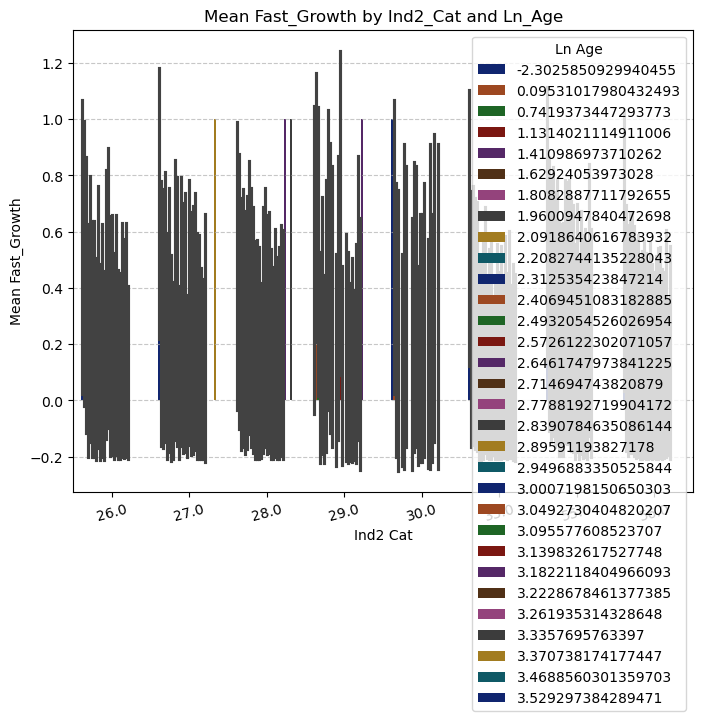

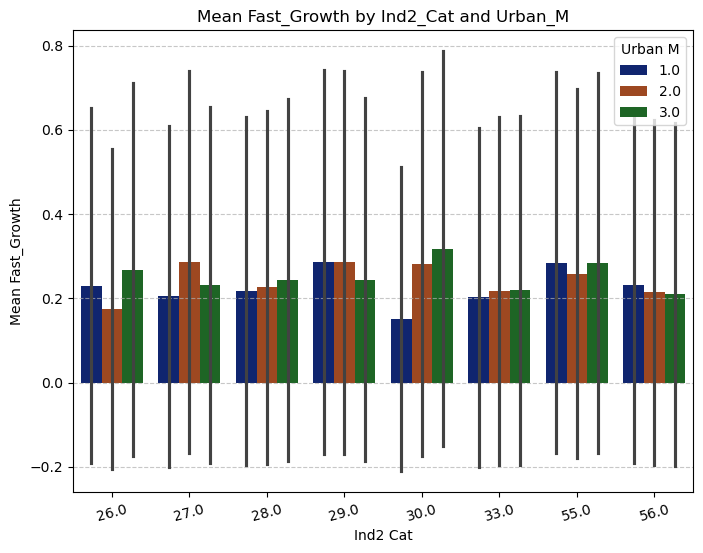

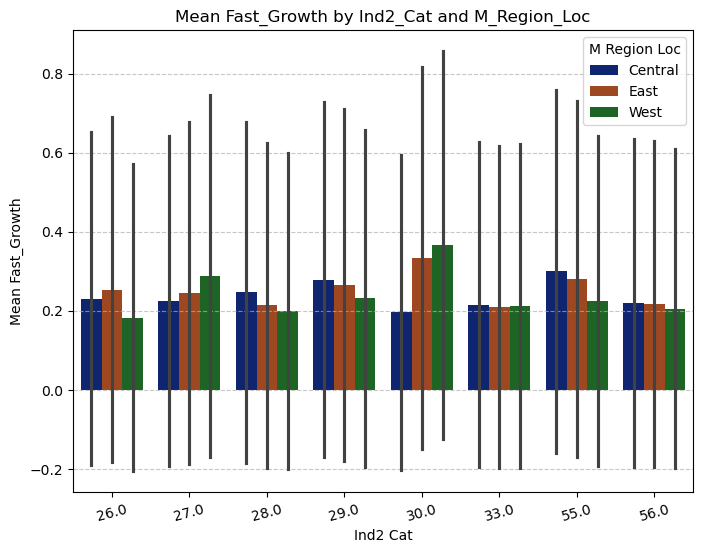

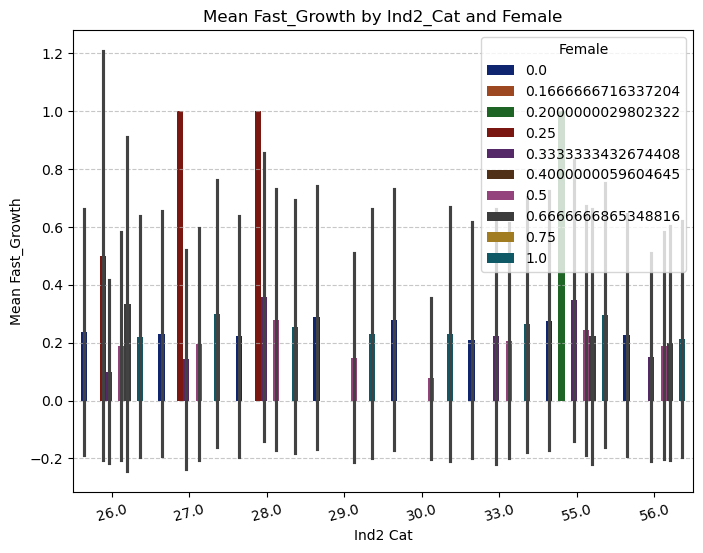

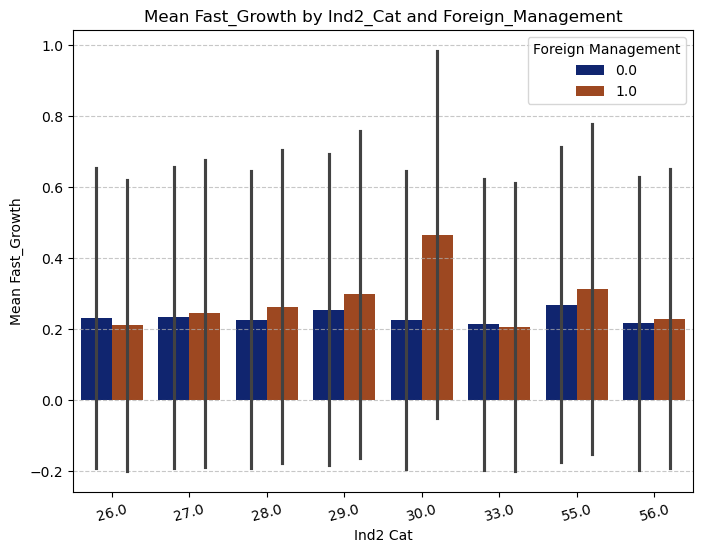

In [152]:
plot_categorical_mean_price(data, 'ind2_cat','ln_age','fast_growth')
plot_categorical_mean_price(data, 'ind2_cat','urban_m','fast_growth')
plot_categorical_mean_price(data, 'ind2_cat','m_region_loc','fast_growth')
plot_categorical_mean_price(data, 'ind2_cat','female','fast_growth') 
plot_categorical_mean_price(data, 'ind2_cat','foreign_management','fast_growth')

In [153]:
interactions = [ "C(ind2_cat)*ln_age",  "C(ind2_cat)*ceo_age",    "C(ind2_cat)*C(m_region_loc)",
    "C(ind2_cat)*female",    "C(ind2_cat)*sales_mil_log",    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*past_d1_sales_mil_log_mod",    "C(ind2_cat)*C(urban_m)",    "C(ind2_cat)*labor_avg_mod",
    "C(ind2_cat)*ln_inoffice_days","sales_mil_log*profit_loss_year","sales_mil_log*ln_age"
]

**Logit Features**

In [155]:
logit_model1 = base_vars
logit_model2 = base_vars + bal_vars + raw_vars
logit_model3 = base_vars + bal_vars + raw_vars + firm_vars + hr_vars
logit_model4 = base_vars + bal_vars + raw_vars + firm_vars + hr_vars + sales_normalized_vars + assets_normalized_vars
logit_model5 = base_vars + bal_vars + raw_vars + firm_vars + hr_vars + sales_normalized_vars + assets_normalized_vars + quad_vars + flag_vars
logit_model6 = base_vars + bal_vars + raw_vars + firm_vars + hr_vars + sales_normalized_vars + assets_normalized_vars + quad_vars + flag_vars + interactions

**Logit Lasso Features**

**Using the broadest logit model**

In [158]:
logit_lasso_model = logit_model6

**Random Forest Features**

In [160]:
rf_model = ['sales_mil_log','past_d1_sales_mil_log_mod','ln_total_assets_bs'] + raw_vars + bal_vars + hr_vars + firm_vars

## Creating Train and Holdout Set

**We do not explicitly create Test set as we would use K Fold validation which randomly seperates training data into folds and uses one of them as test set**

In [163]:
from sklearn.model_selection import train_test_split

data_train, holdout_set = train_test_split(data, test_size=0.2, random_state=42)  # 20% holdout


# Check sizes
print(f"Train: {data_train.shape}, Holdout: {holdout_set.shape}")

Train: (15228, 112), Holdout: (3808, 112)


## Model Performance - RMSE

<span style="font-size: 18px;">**For these models below, we check performances in terms of RMSE. Hence we set scoring to neg_brier_score. We would change this to roc_auc_score afterwards for AUC**

### Logit Models

**Using 5 folds for Cross Validation**

In [168]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [169]:
logit_model_vars = [logit_model1, logit_model2, logit_model3, logit_model4, logit_model5, logit_model6]

**C-value means inverse regularization strength. C = 1/Lambda. We use a very large value of C so that lambda is very low and almost no regularization. That is because we want the model to behave like standard logistic model. As we would make a Lasso model with regularization afterwards**

In [171]:
C_value_logit = [1e20]

**Using fast growth as the dependent variable to check RMSE on each fold for all 6 Logit models**

In [173]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["Logit" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["Logit" + str(i + 1)] = np.sqrt(
        -1 * logit_models["Logit" + str(i + 1)].scores_[1].ravel()
    )

pd.DataFrame(CV_RMSE_folds)

,Logit1,Logit2,Logit3,Logit4,Logit5,Logit6
0,0.400849,0.400585,0.397263,0.398076,0.398206,0.395638
1,0.408557,0.407472,0.406182,0.406760,0.405555,0.403877
2,0.408647,0.407926,0.405580,0.406482,0.404777,0.404101
3,0.415422,0.413552,0.412331,0.411607,0.411462,0.410951
4,0.412782,0.410487,0.406955,0.405860,0.408628,0.406843


### Lasso Logit Model

In [175]:
model_equation = "fast_growth~" + "+".join(logit_lasso_model)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

**We are standardizing all variables so that they have mean 0 and std deviation 1. Without standardization, variables with larger scales (e.g., income in thousands vs. proportions between 0 and 1) will have larger absolute coefficients, making Lasso penalize them more. We want equal penalization for stability of features and enhance feature selection**

In [177]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [178]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = X_train.shape[0] * 4/5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

**Using our range of lambdas and C values to do cross validation to find optimal values. We fit the lasso model at the end using the optimal values**

In [180]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [181]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.430355
1,0.046416,0.001768,0.413361
2,0.021544,0.003810,0.405664
3,0.010000,0.008209,0.402668
4,0.004642,0.017685,0.400980
5,0.002154,0.038101,0.400641
6,0.001000,0.082086,0.400763
7,0.000464,0.176848,0.401158
8,0.000215,0.381008,0.401556
9,0.000100,0.820856,0.401741


**Printing optimal C Value**


In [183]:
print("Optimal C:", logLasso_brier.C_[0])

Optimal C: 0.0381007751642761


**Getting index of the best lambda value**

In [185]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [186]:
best_lambda_i

5

**Adding Lasso model to the RMSE values table for all models and all folds**

In [188]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [189]:
pd.DataFrame(CV_RMSE_folds)

,Logit1,Logit2,Logit3,Logit4,Logit5,Logit6,LASSO
0,0.400849,0.400585,0.397263,0.398076,0.398206,0.395638,0.392934
1,0.408557,0.407472,0.406182,0.406760,0.405555,0.403877,0.400551
2,0.408647,0.407926,0.405580,0.406482,0.404777,0.404101,0.398684
3,0.415422,0.413552,0.412331,0.411607,0.411462,0.410951,0.407776
4,0.412782,0.410487,0.406955,0.405860,0.408628,0.406843,0.403112


### Random Forest

**In rf_model we use only the non transformed features as Random Forest handles transformations itself**

In [192]:
y_train, rf_train = patsy.dmatrices("fast_growth~" + "+".join(rf_model), data_train)
y_holdout, rf_holdout = patsy.dmatrices("fast_growth~" + "+".join(rf_model), holdout_set)

**Setting up parameters to be used in Grid Search**

In [194]:
grid = {
    "n_estimators": [500],  # Number of trees in the forest
    "max_features": [5, 7, 10],  # Number of features per split
    "criterion": ["gini"],  # Splitting criterion
    "min_samples_split": [11, 16, 21],  # Minimum samples required to split a node
}

In [195]:

prob_forest = RandomForestClassifier(random_state=42, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
    verbose=1
)

**Fitting the random forest model on our training set**

In [197]:
prob_forest_fit = prob_forest_grid.fit(rf_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [198]:

prob_forest_cv_results = pd.DataFrame(
    {
        "n_estimators": prob_forest_fit.cv_results_["param_n_estimators"],
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results.sort_values('cv_rmse',ascending = True)

,n_estimators,max_features,min_samples_split,cv_auc,cv_rmse
5,500,7,21,0.683710,0.398642
4,500,7,16,0.682508,0.398728
1,500,5,16,0.682877,0.398741
0,500,5,11,0.683346,0.398745
2,500,5,21,0.683032,0.398808
8,500,10,21,0.682448,0.398814
3,500,7,11,0.681659,0.398980
6,500,10,11,0.681017,0.399175
7,500,10,16,0.680042,0.399233


**Adding Random Forest RMSE on 5 folds to the RMSE Summary Table**

In [200]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

In [201]:
pd.DataFrame(CV_RMSE_folds)

,Logit1,Logit2,Logit3,Logit4,Logit5,Logit6,LASSO,RF
0,0.400849,0.400585,0.397263,0.398076,0.398206,0.395638,0.392934,0.390106
1,0.408557,0.407472,0.406182,0.406760,0.405555,0.403877,0.400551,0.397370
2,0.408647,0.407926,0.405580,0.406482,0.404777,0.404101,0.398684,0.400340
3,0.415422,0.413552,0.412331,0.411607,0.411462,0.410951,0.407776,0.406038
4,0.412782,0.410487,0.406955,0.405860,0.408628,0.406843,0.403112,0.399188


## Models Performances - AUC

### Logit Models

In [204]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["Logit" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["Logit" + str(i + 1)] = logit_models["Logit" + str(i + 1)].scores_[1].ravel()

### Lasso Model

In [207]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [209]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

### Random Forest Model

In [212]:
prob_forest = RandomForestClassifier(random_state=42, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring="roc_auc",
    verbose=0
)

prob_forest_fit = prob_forest_grid.fit(rf_train, y_train)

In [213]:
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .loc[
        lambda x: x["mean_test_score"] == x["mean_test_score"].max()  # Find the row with the best AUC score
    ]
    .filter(like="split")  # Filter for fold-wise results
    .iloc[0].values[1:]  # Get the values for the first fold
)


In [214]:
CV_AUC_folds

{'Logit1': array([0.64304325, 0.62708432, 0.63780387, 0.61285732, 0.62295523]),
 'Logit2': array([0.64586519, 0.62274681, 0.645296  , 0.62455018, 0.6247627 ]),
 'Logit3': array([0.67696835, 0.63582276, 0.66495561, 0.63534763, 0.65031931]),
 'Logit4': array([0.67018132, 0.63063364, 0.65808545, 0.64050817, 0.65785683]),
 'Logit5': array([0.668606  , 0.64054082, 0.66878991, 0.64081368, 0.63909728]),
 'Logit6': array([0.686019  , 0.65924433, 0.67048431, 0.63971782, 0.65429806]),
 'LASSO': array([0.69913254, 0.68006365, 0.68667366, 0.65434325, 0.67843543]),
 'RF': array([0.7035853079970726, 0.684744142913706, 0.680718583417714,
        0.6627533473733023, 0.6867487971598198], dtype=object)}

In [215]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
best_n_estimators =  prob_forest_fit.best_params_["n_estimators"]
prob_forest_fit.best_params_

{'criterion': 'gini',
 'max_features': 7,
 'min_samples_split': 21,
 'n_estimators': 500}

In [216]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
    & (prob_forest_cv_results.n_estimators == best_n_estimators)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [217]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]

## Summary of RMSE and AUC on 5 folds. Overall Summary of Results of All Models

**Summary of RMSE on 5 folds**

In [220]:
pd.DataFrame(CV_RMSE_folds)

,Logit1,Logit2,Logit3,Logit4,Logit5,Logit6,LASSO,RF
0,0.400849,0.400585,0.397263,0.398076,0.398206,0.395638,0.392934,0.390106
1,0.408557,0.407472,0.406182,0.406760,0.405555,0.403877,0.400551,0.397370
2,0.408647,0.407926,0.405580,0.406482,0.404777,0.404101,0.398684,0.400340
3,0.415422,0.413552,0.412331,0.411607,0.411462,0.410951,0.407776,0.406038
4,0.412782,0.410487,0.406955,0.405860,0.408628,0.406843,0.403112,0.399188


**Summary of AUC on 5 folds**

In [222]:
pd.DataFrame(CV_AUC_folds)

,Logit1,Logit2,Logit3,Logit4,Logit5,Logit6,LASSO,RF
0,0.643043,0.645865,0.676968,0.670181,0.668606,0.686019,0.699133,0.703585
1,0.627084,0.622747,0.635823,0.630634,0.640541,0.659244,0.680064,0.684744
2,0.637804,0.645296,0.664956,0.658085,0.668790,0.670484,0.686674,0.680719
3,0.612857,0.624550,0.635348,0.640508,0.640814,0.639718,0.654343,0.662753
4,0.622955,0.624763,0.650319,0.657857,0.639097,0.654298,0.678435,0.686749


**Summary Table for best results**

In [224]:
summary

,Number of Coefficients,CV RMSE,CV AUC
Logit1,14.0,0.409252,0.628749
Logit2,35.0,0.408004,0.632644
Logit3,50.0,0.405662,0.652683
Logit4,65.0,0.405757,0.651453
Logit5,100.0,0.405726,0.651570
Logit6,187.0,0.404282,0.661953
LASSO,89.0,0.400611,0.679730
RF,n.a.,0.398642,0.683710


<span style="font-size: 18px;">Looking at the results based on our cross validation on the training set, it seems that Random Forest gives the best results in terms of RMSE and AUC. However, the difference is minimal compared to Lasso. Random Forest's ease of use it make it more efficient as it takes in raw variables without any transformation or interactions and does the heavy lifting itself. We will check all these models in terms of classification based on thresholds as well for further understanding.

# Part 2: Classification and Best Thresholds

<span style="font-size: 18px;">Introducing Loss Function

<span style="font-size: 18px;">**Assigning high weightage to misclassifying a company as non-fast growing when they are fast growing**

<span style="font-size: 18px;">**From the perspective of an investment fund, we need to penalize if we fail to recognize a company as fast growing when in reality it shows signs of being one. The profit made on investment on a fast growing company would be much larger than the loss made on a company that is classified as fast growing but is not. Hence, we have a higher cost (4:1) for not recognizing a company as fast growing than misclassifying some which do not have fast growth.**

In [478]:
FP = 1
FN = 4
cost = FN / FP

In [480]:
prevelance = y_train.sum() / len(y_train)

## For Logit and Lasso Logit

<span style="font-size: 18px;">**Checking expected loss, rmse and auc on average and fold level**

In [484]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

predicted_probabilities = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []
    all_probs = []  # Store all probabilities for this model

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i

    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        
        # Store probabilities for this fold
        all_probs.append(pred_fold)

        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold += 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # Store predicted probabilities for all folds in the dictionary
    predicted_probabilities[model_name] = np.concatenate(all_probs)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords



In [485]:
predicted_probabilities

{'Logit1': array([0.20428629, 0.30395707, 0.18097129, ..., 0.13858581, 0.14796675,
        0.14363504]),
 'Logit2': array([0.21189229, 0.28560453, 0.21188284, ..., 0.15318207, 0.15623987,
        0.15170877]),
 'Logit3': array([0.1952091 , 0.34616495, 0.2059691 , ..., 0.17858806, 0.12263381,
        0.14859672]),
 'Logit4': array([0.20050514, 0.34580037, 0.21477209, ..., 0.18000179, 0.11831518,
        0.14307112]),
 'Logit5': array([0.20136857, 0.3396321 , 0.21296689, ..., 0.17446251, 0.1283057 ,
        0.15178397]),
 'Logit6': array([0.18274406, 0.35775617, 0.1915045 , ..., 0.16579007, 0.10790908,
        0.13148768]),
 'LASSO': array([0.1652088 , 0.28880451, 0.1790357 , ..., 0.18989468, 0.09447144,
        0.12321383])}

<span style="font-size: 18px;">**Plotting densities of Probabilities for sense checking distribution**

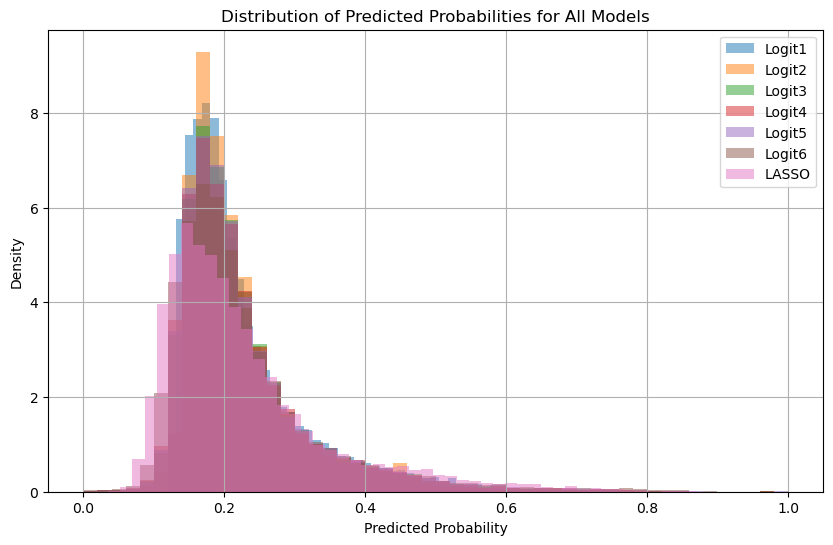

In [486]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop through each model and plot its predicted probabilities
for model_name, probs in predicted_probabilities.items():
    plt.hist(probs, bins=50, alpha=0.5, label=model_name, density=True)

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities for All Models")
plt.legend()
plt.grid(True)
plt.show()


<span style="font-size: 18px;">**Summary of Logits and Lasso models with selected loss function**

In [488]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [489]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,Logit1,0.212116,0.222907,0.669820,0.669951
1,Logit2,0.218807,0.220918,0.674746,0.682430
2,Logit3,0.197426,0.193456,0.647100,0.656158
3,Logit4,0.199673,0.202530,0.647098,0.640722
4,Logit5,0.205369,0.242005,0.652550,0.676519
5,Logit6,0.197502,0.203758,0.633704,0.646634
6,LASSO,0.199320,0.226445,0.616564,0.614122


<span style="font-size: 18px;">**Loss Plot based on Threshold for 5th Fold**

Plotting for Lasso due to lowest Loss. Can be done for all logit models as well

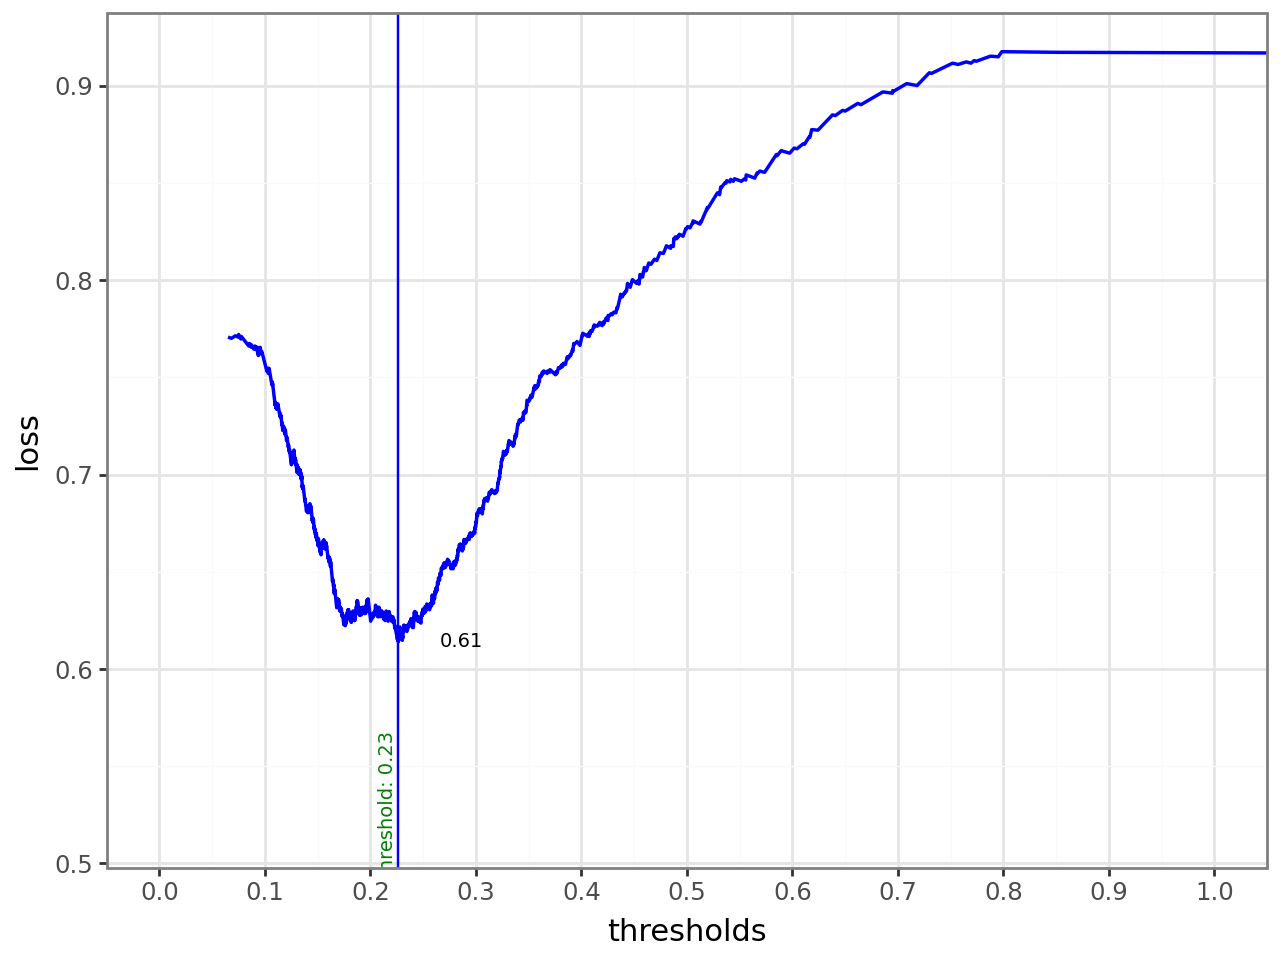

In [490]:
model_to_plot = "LASSO"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

In [491]:
best_thresholds_cv

{'Logit1': 0.21211646019948865,
 'Logit2': 0.21880656220673722,
 'Logit3': 0.19742575235214038,
 'Logit4': 0.19967259270970672,
 'Logit5': 0.20536881814369484,
 'Logit6': 0.19750239030616448,
 'LASSO': 0.19931957825993263}

<span style="font-size: 18px;">**ROC plot on 5th Fold**

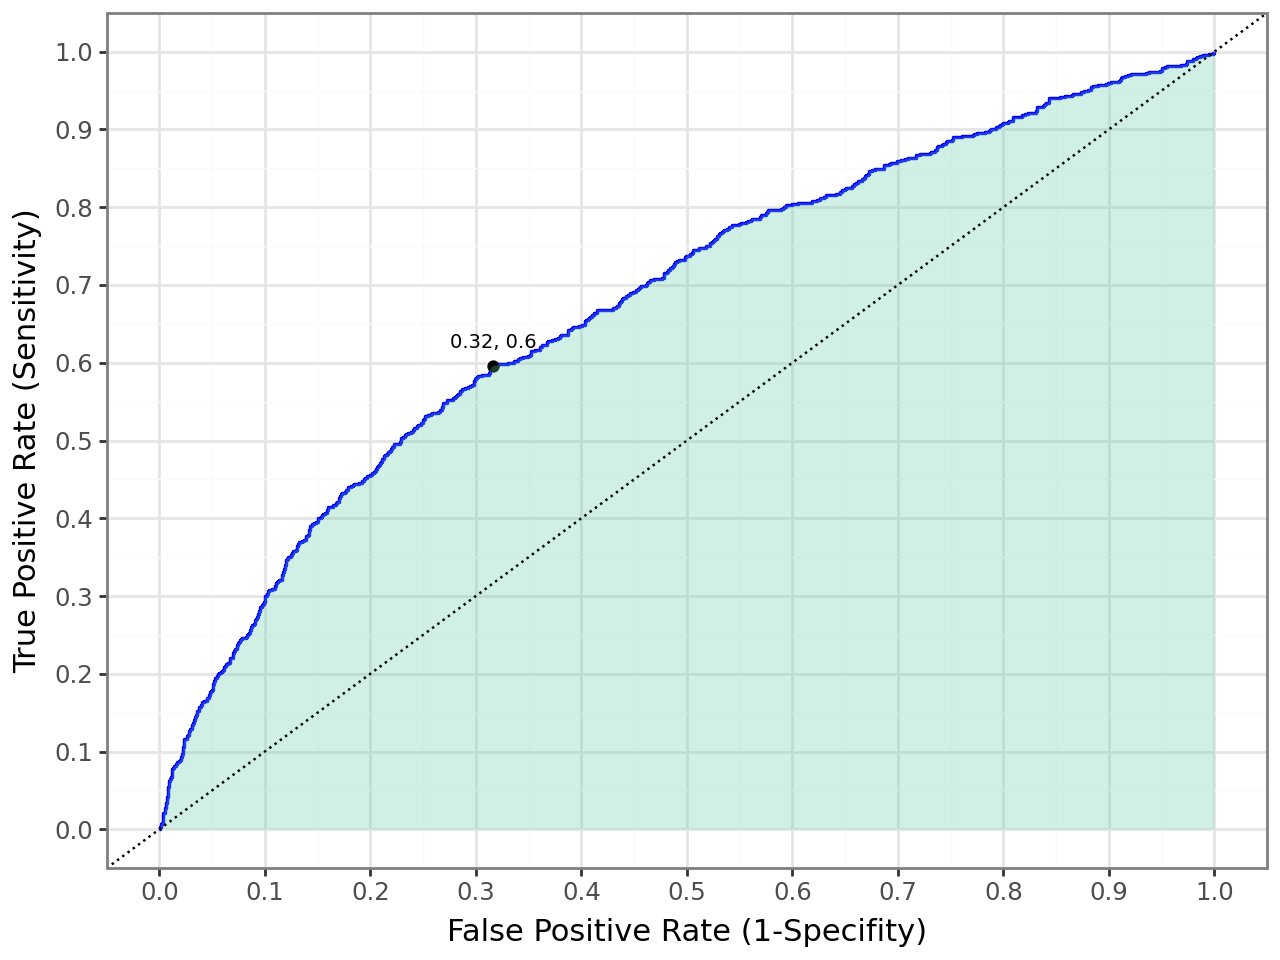

In [492]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

## Random Forest

In [494]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rf_model), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rf_model), holdout_set)

In [495]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [498]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

<span style="font-size: 18px;">**Summary for RF model based on Loss function**

In [499]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.399,0.684,0.208,0.197,0.612,0.609


<span style="font-size: 18px;">**Loss function for RF on 5th fold**

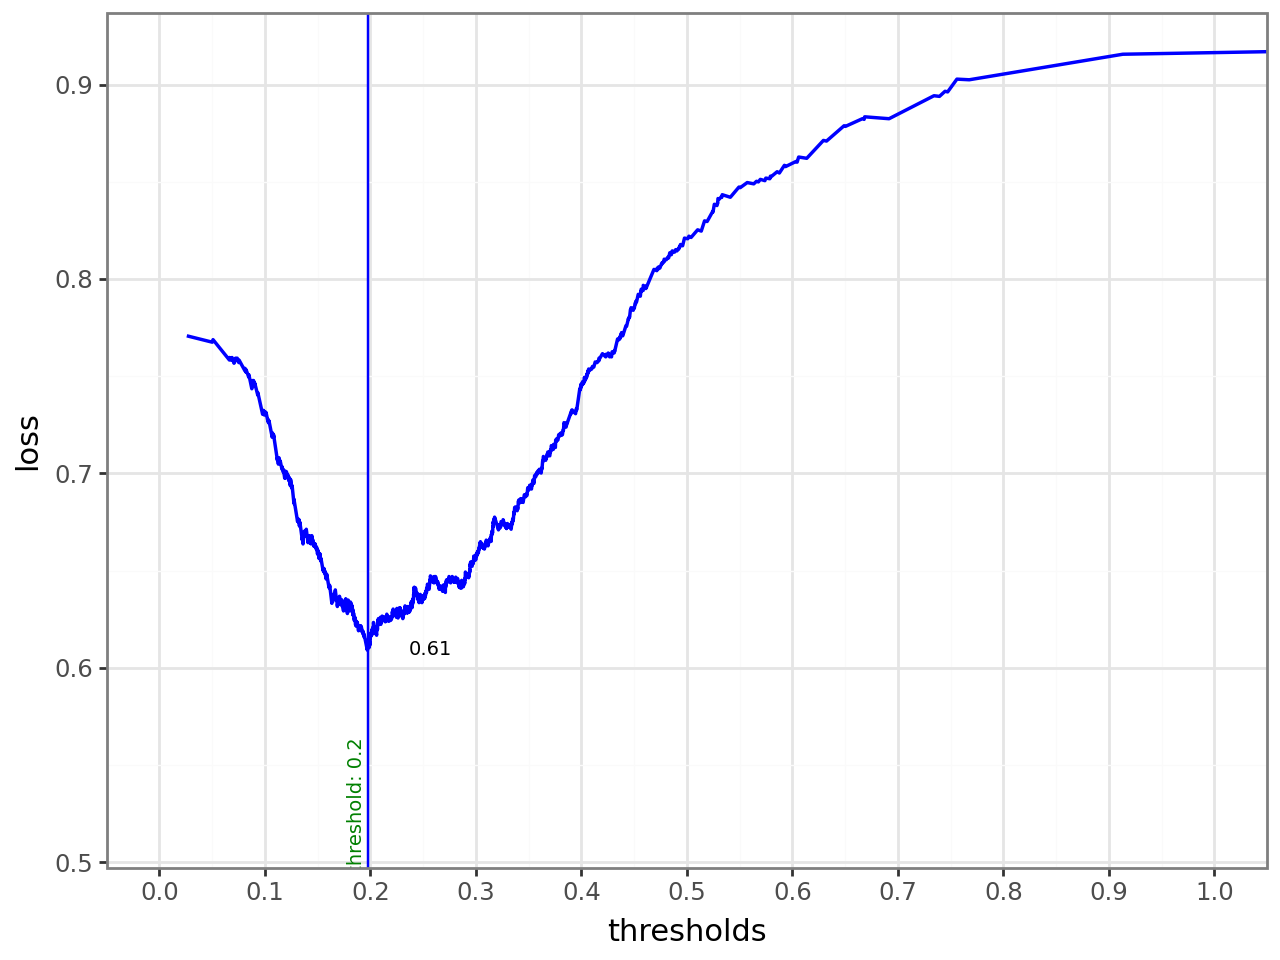

In [500]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

<span style="font-size: 18px;">**ROC Plot for RF on 5th fold**

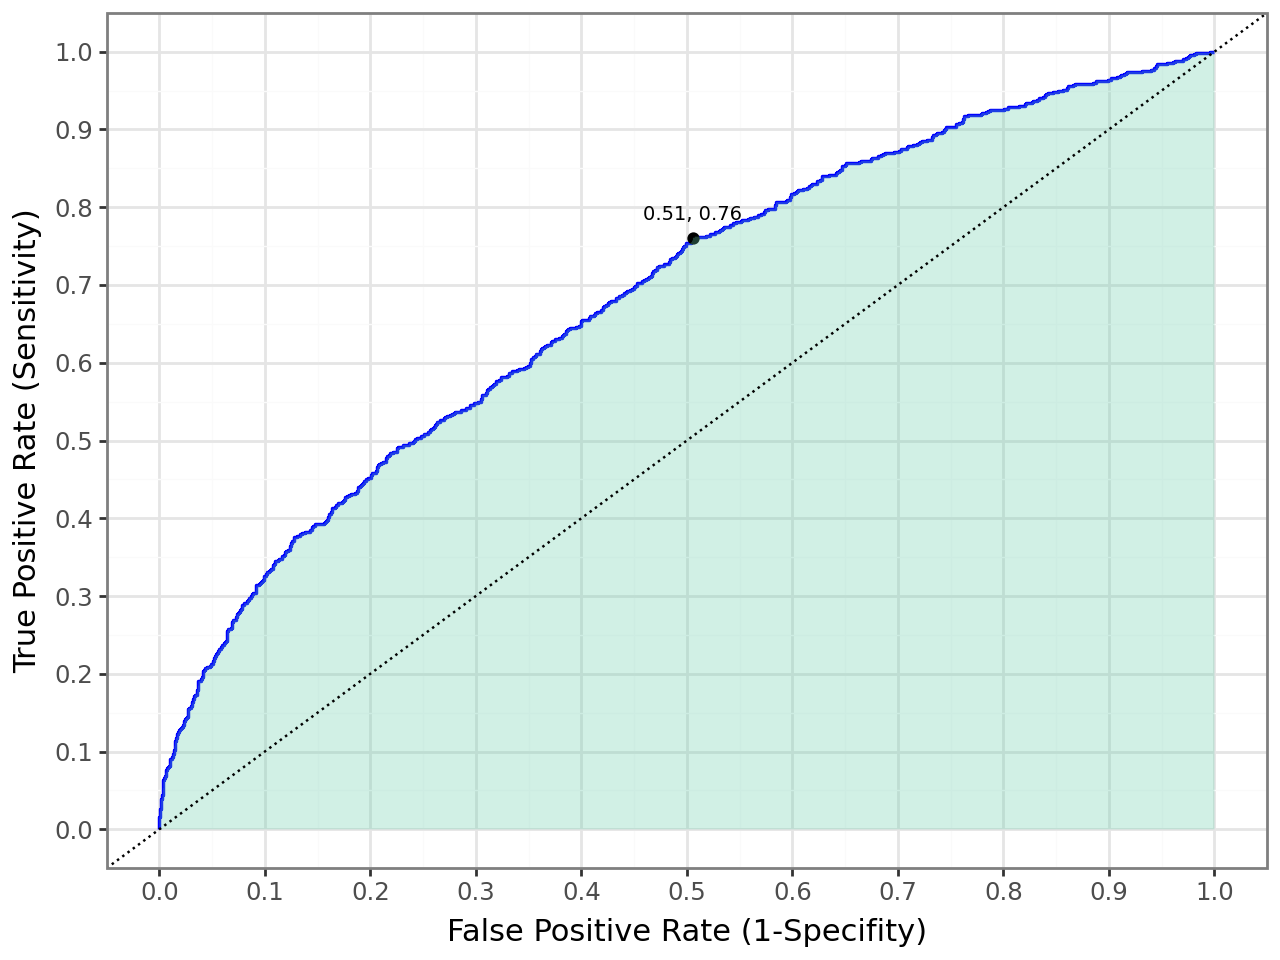

In [501]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

## Summary of Results for All Models

In [504]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

<span style="font-size: 18px;">**Complete Summary Table for All Models**

In [510]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
Logit1,14.0,0.409252,0.628749,0.212116,0.669820
Logit2,35.0,0.408004,0.632644,0.218807,0.674746
Logit3,50.0,0.405662,0.652683,0.197426,0.647100
Logit4,65.0,0.405757,0.651453,0.199673,0.647098
Logit5,100.0,0.405726,0.651570,0.205369,0.652550
Logit6,187.0,0.404282,0.661953,0.197502,0.633704
LASSO,89.0,0.400611,0.679730,0.199320,0.616564
RF,n.a.,0.398642,0.683710,0.207702,0.611835


# Part 3: Discussion of Results

<span style="font-size: 18px;">**Our best model in terms of Avg Expected Loss is Random Forest. We will analyse this further**

## RMSE

In [517]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.401

## Checking Loss on Holdout Set

In [519]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.628

## ROC AUC in Holdout Set

In [520]:
holdout_set["best_rf_pred_proba"] = prob_forest_fit.predict_proba(rfvars_holdout)[:, 1]

In [523]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.681

## Calibration Curve

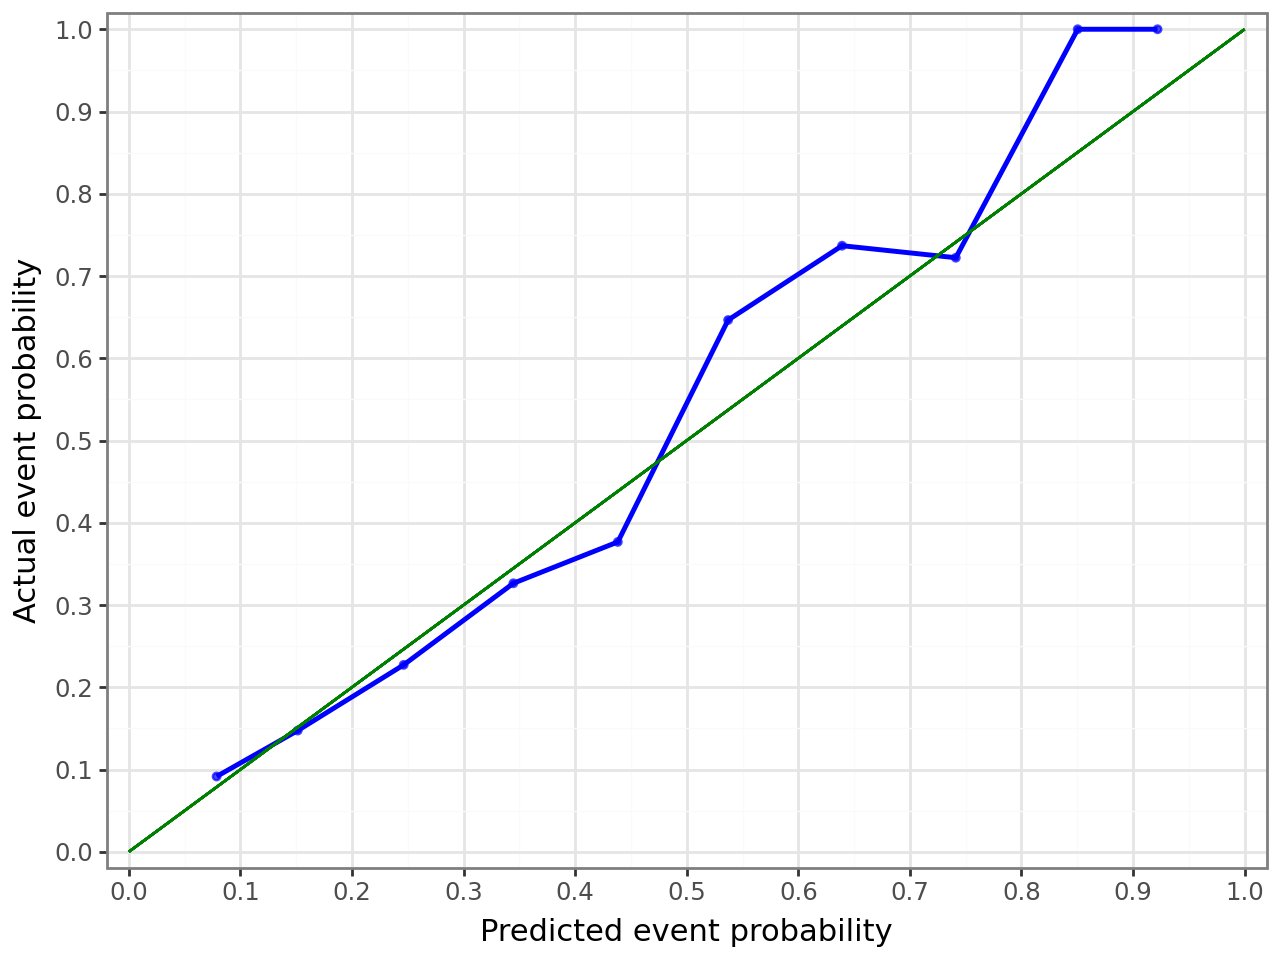

In [575]:
create_calibration_plot(
    holdout_set,
    file_name="RF-calibration",
    prob_var="best_rf_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

## Confusion Table

In [528]:
rf_class_prediction = prob_forest_fit.predict(rfvars_holdout)

values, counts = np.unique(rf_class_prediction.tolist(), return_counts=True)
print(values[0], " (no fast growth): ", counts[0])
print(values[1], " (fast growth): ", counts[1])

0.0  (no fast growth):  3642
1.0  (fast growth):  166


<span style="font-size: 18px;"> **Optimal Threshold for RF is 0.20**

In [563]:
holdout_prediction = np.where(holdout_set["best_rf_pred_proba"] <= 0.20, 0, 1)
cm_object1b = confusion_matrix(
    holdout_set["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual No Fast Growth", "Actual Fast Growth"],
    columns=["Predicted No Fast Growth", "Predicted Fast Growth"],
)
cm1b

,Predicted No Fast Growth,Predicted Fast Growth
Actual No Fast Growth,1489,1444
Actual Fast Growth,238,637


## ROC Plot on Holdout Set

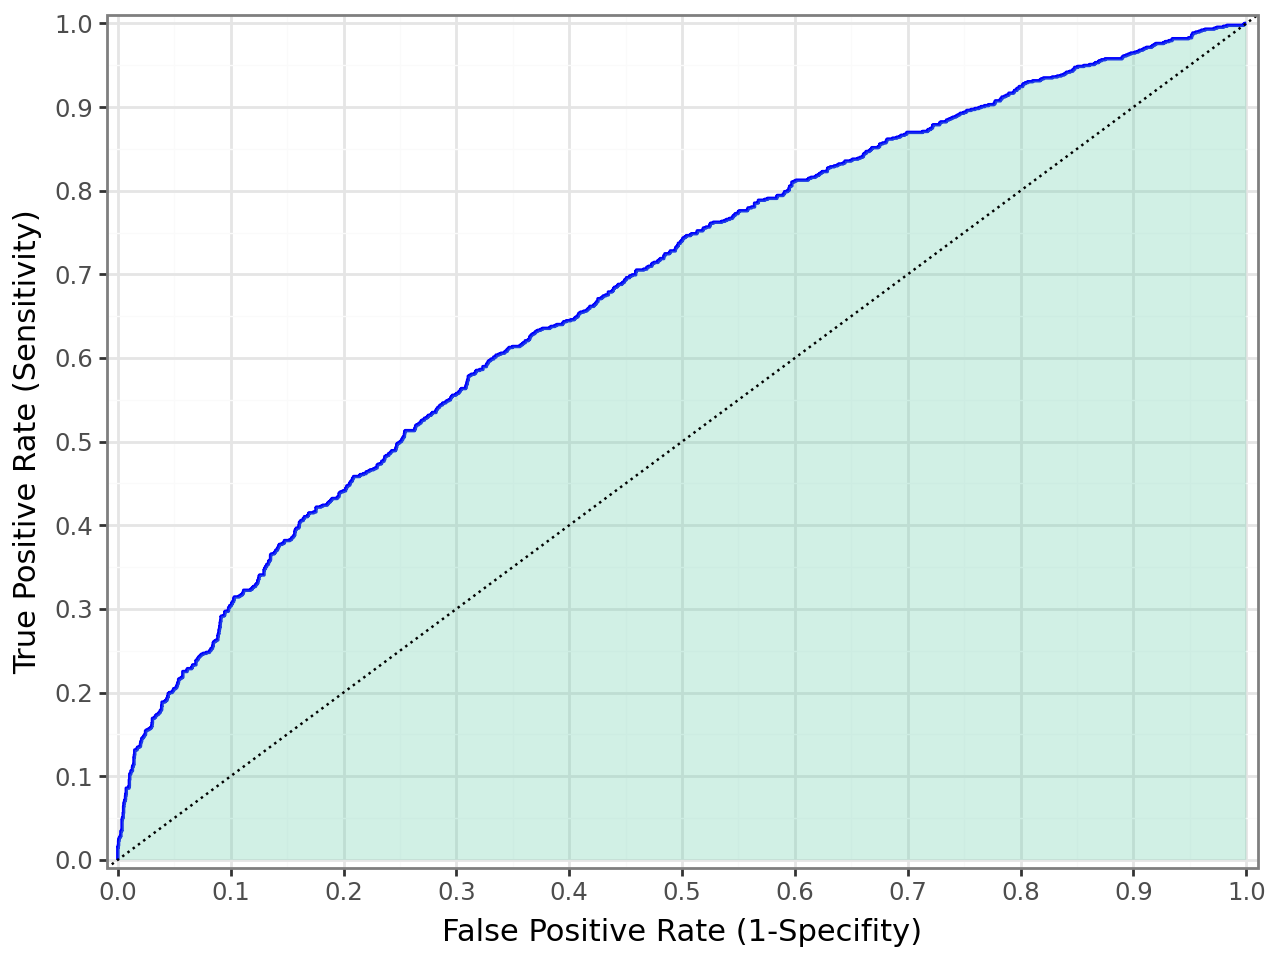

In [565]:
create_roc_plot(holdout_set["fast_growth"], holdout_set["best_rf_pred_proba"])

## Discussion of Results

<span style="font-size: 18px;">**As discussed initially, we set the cost at 4 with FN:FP at 4:1. We observed that the Random Forest model gave us the best results in terms of loss, RMSE and AUC. We use that model with the associated cost on our holdout set to check the results. The RMSE of this model on holdout set is 0.401, Loss is 0.628 and AUC is 0.681. Looking at the calibration curve, we observe it is close to the 45 degree line but it deviates from the diagonal at higher probabilities. This means that the model appears well-calibrated at lower probabilities but slightly deviates at higher probabilities.**

<span style="font-size: 18px;">For the classification, the optimal threshold for the RF model is set at 0.20. Based on this threshold, the confusion table is created. Based on this we observe:

<span style="font-size: 18px;">**Accuracy = (TP+TN)/(TP+TN+FP+FN) = 55.8%**-> Around 56% of all observations classified correctly.

<span style="font-size: 18px;">**Recall = TP/(TP+FN) =  72.8%** -> It captures most of the actual "Fast Growth" cases, meaning it has low false negatives.

<span style="font-size: 18px;">**Precision = TP/(FP+TP) = 30.6%** -> The model overpredicts fast growth, hence many False Positives are present.

<span style="font-size: 18px;">**Specificity = TN/(TN+FP) =  50.8%** -> The model misclassifies non fast growth companies nearly half of the times. This is because we do not want to risk misclassifying a fast growth company as non fast growing. Hence, low threshold misclassifies the non fast growing companies as fast growing.

<span style="font-size: 18px;">**The model favors recall over precision, meaning it prioritizes detecting fast growth at the cost of many false positives.
As discussed at the start, our investment fund would encounter a higher loss of missing out on a fast growing company as compared to the loss made on the investment on a non fast growing company. Hence, missing "Fast Growth" companies is worse than misclassifying "Non Fast Growth" companies. Our model would be able to correctly predict 3 out of 4 of all fast growing companies. However, this comes at a cost of misclassifying 2 companies as fast growing for each correct "Fast Growing" classification. Based on our use case this tradeoff is acceptable for our investment fund, so this model is suitable for our cause**